# World Data League 2022

## 🎯 Challenge
*Predicting a safety score for women in Costa Rica*


## Team: GeoNEAS
## 👥 Authors
* David Gamba
* Melissa Montes
* Juan Diego Arango
* Irune Lansorena
* Santiago Cardona

## 💻 Development

Gender-based violence problems have been one of the greatest social plights in Latin America. According to the UN, between 60% and 76% of women (around 2 out of every 3) has been the victim of at least one type of gender-based violence. In addition, 1 out of every 3 women that has been a victim of physical, psychological and/or sexual violence, has suffered it at the hands of a perpetrator who is her intimate partner. [1]  
  
Authorities have to deal with the fact that gender-based crimes are heavily underreported [2, 3]. One of the reasons is the fact that judicial system often lacks understanding about the nature of the crimes, leading to situations that often make women suffer revictimizing situations [4].  
  
Some progress has been made to mitigate this, both in awareness and strengthening of laws. To accelerate this, it would be ideal to provide data tools that aid the reporting and policy making to both women and local authorities [5]. Although there are some existing datasets that aggregate crimes in Costa Rica, the current datasets lack granularity in both time and space to allow a more comprehensive understanding of gender violence.  
  
Our team, GeoNEAS, is proposing a tool to empower women with data, allowing them to report gender-based crimes at a coordinate granularity. Women will be able to identify in which zones of a city are they at most risk, and authorities will have this information available to formulate public policies related to this issue.  



0. **Data and preprocessing.** Here we explain where to find the big chunk of code that corresponds to preprocessing.
1. **Exploratory Data Analysis** Here we analyze crimes and sexual harassment dataset.
2. **Forecast** We develop a forecast model for crimes per districts
3. **Cases simulation and spatial model** Here we simulated crimes in San Jose, considering assumptions of qualitative risk index of violence against womens. Then, we built a spatial model with built environment variables to check their influence in the crimes.
4. **Demo preparation** We introduce assumptions about the demo model.


### Libraries

We install additional libraries used in the project

In [ ]:
!pip install -q -U altair_data_server contextily hdbscan numpy scipy patsy pandas fiona shapely pyproj rtree ortools
!pip install geopandas h3pandas
!pip install contextily
!pip install pandana pysal
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import altair as alt
from pandas.api.types import CategoricalDtype
import numpy as np
import json
import os
import geopandas as gpd
import h3pandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime

import hdbscan
import random

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import cross_val_score, KFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin

from tqdm import tqdm
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
from statsmodels.graphics.tsaplots import plot_acf

from itertools import combinations
from sklearn.preprocessing import MinMaxScaler

from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg
import contextily

%pylab inline
%matplotlib inline  

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB t

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0. Data and preprocessing

One crucial part of this project was to prepare the data share by Urban Analytic to conduct Exploratory Data Analysis (EDA), forecast, and analysis

In https://dagshub.com/astenuz/geoneas-wdl/src/master/soft-s2/notebooks/data_acquisition.ipynb you can check the data acquisition and preprocessing of different sources like:

- Geographic Data of San Jose from Urban Analytica
- **Spatial Feautre Engineering for demand estimation** The most important part that bouilds the features to characterize a patch of land and which will be used to train a model that can model number of crimes considering simulate data in San José, Costa Rica

**VERY IMPORTANT NOTE: We've been using google drive as data repository. We try to keep the data organized. However, This time the development of many more notebooks has complicated our previous approach were we stitched the notebooks and replaced the data paths by data uploaded in google storage. Due to time constrains some part of this code is assumming the data is available through google Drive. In case of requiring re-running the solution, we'd be glad to explain the correct process to running and generating new data accounting the google drive data source**

### 1. Exploratory Data Analysis (EDA)

In this part we are going to conduct the EDA for crime and sexual harassment datasets of Costa Rica to identify trends in the data to know which of them have more prevalence among women. Identifying which kinds of crimes are higher in Costa Rica to prioritise features to built a safety index for women and to forecast the most dangerous zones.

The most important findings were related to the granularity of data. Crimes is a large dataset with information of datetime, categories and subcategories consequently we could identify some trends per district. Furthermore, sexual harassment dataset did not have enough data to use in models consequently we conduct an analysis in the crimes dataset to identify prevalence of crimes among women to forecast per district.

In [ ]:
#Reading the data for crimes and sexual harassment

BASE_PATH = "/content/drive/MyDrive/GeoNEAS/gender-s3/data/raw/"

crimes = pd.read_csv(BASE_PATH + "urbanalytica_datasets/datasets/costa_rica_crime_data_english/costa_rica_crimes_english.csv")
sex_har = pd.read_csv(BASE_PATH + "urbanalytica_datasets/datasets/costa_rica_street_harassement_english.csv")

In [ ]:
crimes.head()

Unnamed: 0    Crime SubtypeCrime      Date                 Time  \
0          0  ASSAULT  COLD WEAPON  08.01.22  06:00:00 - 08:59:59   
1          1  ASSAULT  COLD WEAPON  12.01.22  12:00:00 - 14:59:59   
2          2  ASSAULT  COLD WEAPON  13.01.22  18:00:00 - 20:59:59   
3          3  ASSAULT  COLD WEAPON  15.01.22  03:00:00 - 05:59:59   
4          4  ASSAULT  COLD WEAPON  13.01.22  15:00:00 - 17:59:59   

                                       SubtypeVictim      Age   Gender  \
0                            LOTTERY SELLER [PERSON]  >18 y/o   female   
1  PUBLIC SERVICE/LEGAL OR ILLEGAL TAXI/BUS [VEHI...  unknown  unknown   
2                                PEDESTRIAN [PERSON]  >18 y/o   female   
3                                PEDESTRIAN [PERSON]  >18 y/o     male   
4                                PEDESTRIAN [PERSON]  >18 y/o   female   

   Nationality    Province      Canton   District  
0   COSTA RICA    SAN JOSE    SAN JOSE   HOSPITAL  
1  Desconocido  PUNTARENAS  PUNTARENAS  CHACARITA  
2   COSTA RICA    SAN JOSE      ASERRI     ASERRI  
3    NICARAGUA    SAN JOSE      ASERRI     ASERRI  
4   COSTA RICA    SAN JOSE    SAN JOSE   HOSPITAL

In [ ]:
sex_har.head()

province         canton                district  \
0     Heredia        Heredia                 Heredia   
1    San Jose     Goicoechea           Calle Blancos   
2     Cartago      Turrialba               Turrialba   
3     Cartago        Cartago                Oriental   
4  Puntarenas  Perez Zeledon  San Isidro del General   

                    public_prosecutors_office  sexual_harassement  \
0                  Fiscalía Heredia (Adjunta)                   1   
1  Fiscalía II Circuito San José (goicoechea)                   0   
2                          Fiscalía Turrialba                  14   
3                            Fiscalía Cartago                   0   
4                Fiscalía I Circuito Zona Sur                   1   

   exhibitionism  pursuit_or_cornering  production_of_audiovisual_material  \
0             10                     3                                   0   
1             12                     3                                   5   
2              1                     0                                   2   
3             10                     4                                   3   
4              7                     8                                   0   

   sexual_harassement_law  
0                      15  
1                       1  
2                       0  
3                       0  
4                       0

We could identify similarities and differences in the information on the datasets. The main similarity is related to the information about geographic resolution (province, canton, and district). The crimes dataset reports each crime per row with information about type and sub type of crime, date, hour, victim, age, sex, and nationality. On the other hand, the sexual harassment dataset contains aggregate data per geographic resolution about different kinds of sexual harassment: sexual harassment, exhibitonism, pursuit_or_cornering, production_of_audiovisual_material, and sexual_harassment_law

We are going to conduct an analysis per dataset

#### 1.1. Crimes dataset


##### 1.1.1 General Analysis

In [ ]:
crimes["Count"] = 1 #Column to aggregate and count data
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648226 entries, 0 to 648225
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     648226 non-null  object
 1   Crime          648208 non-null  object
 2   SubtypeCrime   648208 non-null  object
 3   Date           648208 non-null  object
 4   Time           648208 non-null  object
 5   SubtypeVictim  648208 non-null  object
 6   Age            648208 non-null  object
 7   Gender         648208 non-null  object
 8   Nationality    648208 non-null  object
 9   Province       648208 non-null  object
 10  Canton         648208 non-null  object
 11  District       648208 non-null  object
 12  Count          648226 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 64.3+ MB


In [ ]:
crimes.isna().sum()

Unnamed: 0        0
Crime            18
SubtypeCrime     18
Date             18
Time             18
SubtypeVictim    18
Age              18
Gender           18
Nationality      18
Province         18
Canton           18
District         18
Count             0
dtype: int64

Crimes dataset contains 648226 crimes. All of the columns are related to string or datetime info. We are going to drop null values

We are going to count how many crimes per type are.

In [ ]:
crimes.dropna(inplace = True)
crimes.count()

Unnamed: 0       648208
Crime            648208
SubtypeCrime     648208
Date             648208
Time             648208
SubtypeVictim    648208
Age              648208
Gender           648208
Nationality      648208
Province         648208
Canton           648208
District         648208
Count            648208
dtype: int64

Crime
ASSAULT              180750
HOMICIDE               4656
ROBBERY              149743
THEFT                201244
VEHICLE THEFT         54509
VEHICLE VANDALISM     57306
Name: Count, dtype: int64


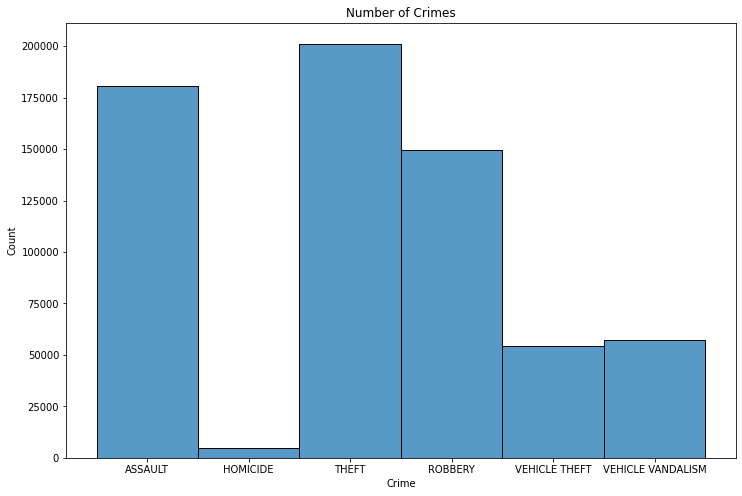

In [ ]:
print(crimes.groupby(["Crime"])["Count"].count())

#sns.set(style="whitegrid")
fig = plt.figure(figsize = (12, 8))
sns.histplot(data = crimes, x = "Crime")

#plt.xticks(df.Crime)
plt.title("Number of Crimes")
#plt.savefig("Trips_day.png")
plt.show()
fig.savefig("Number_crimes_general", dpi = 300)

Most of the crimes are related theft (31%), assault (28.8%), and robbery (23.1%). Homicides reaches 0.71% of the crimes.

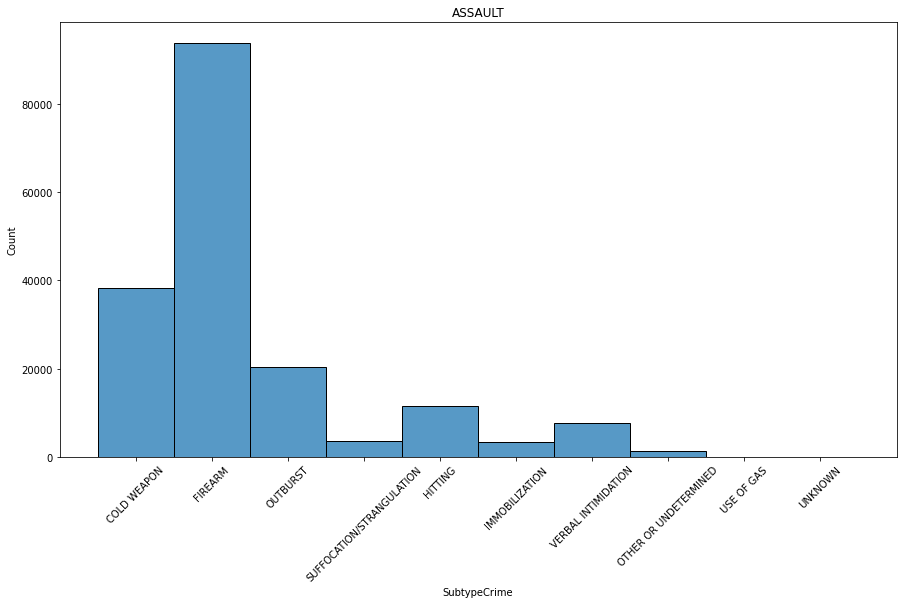

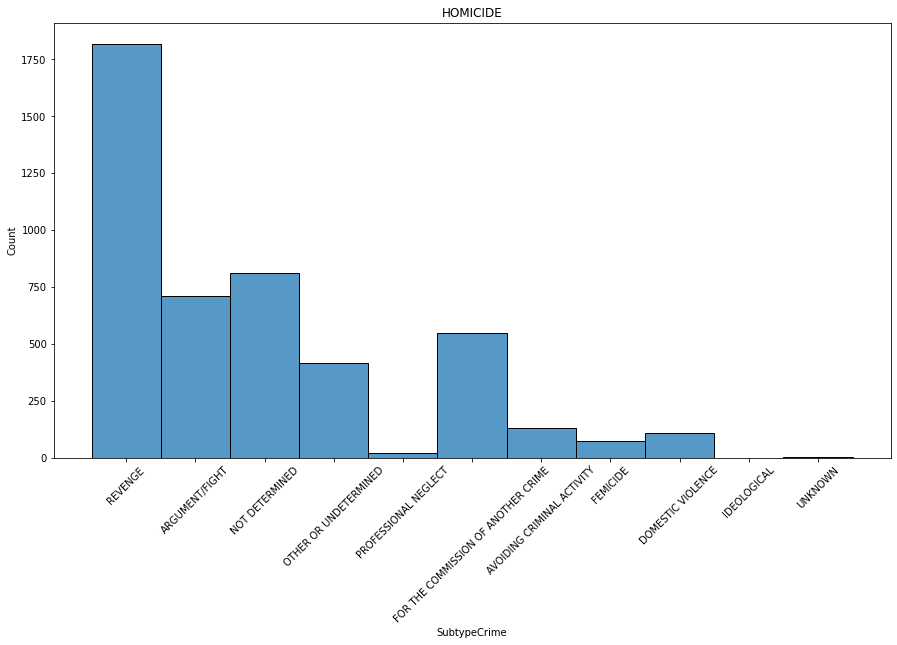

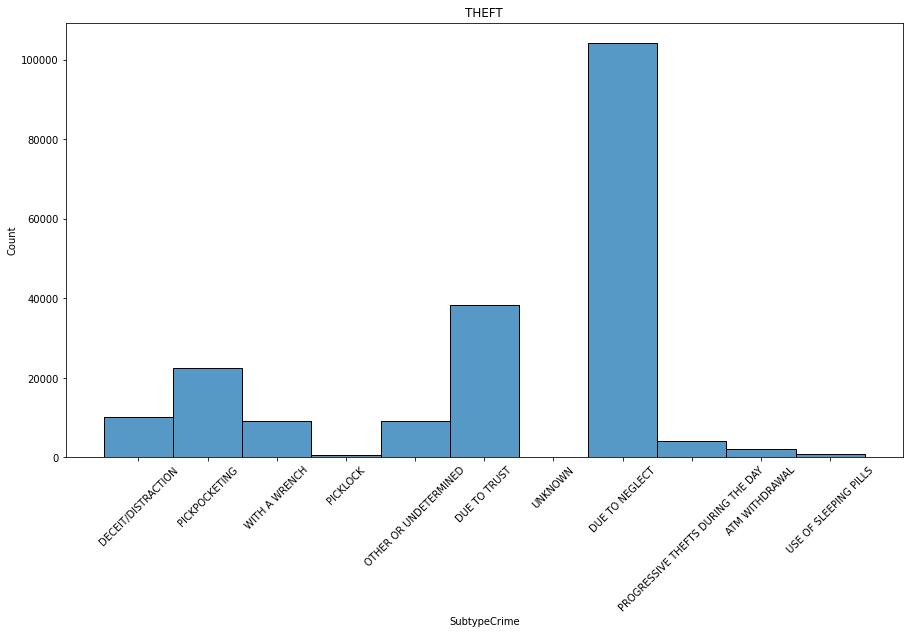

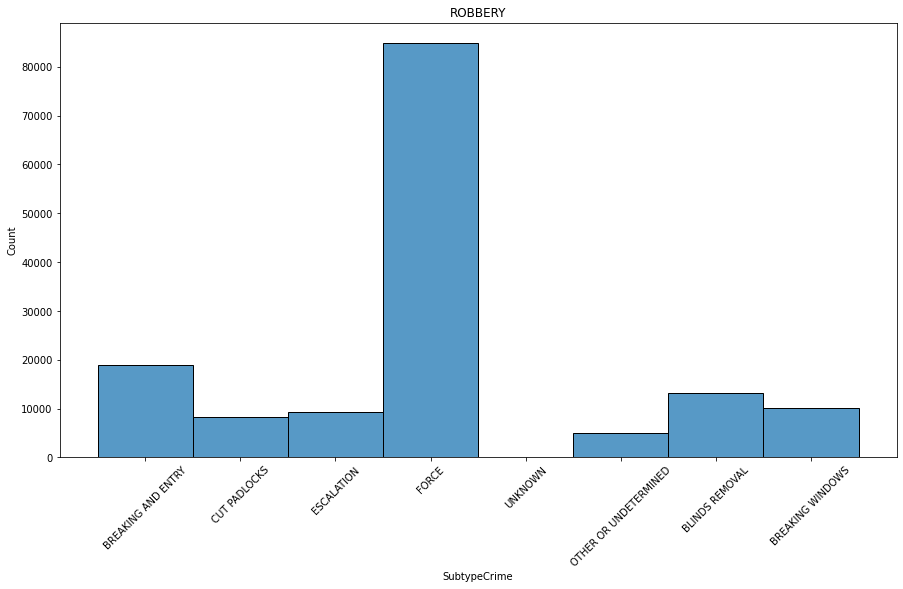

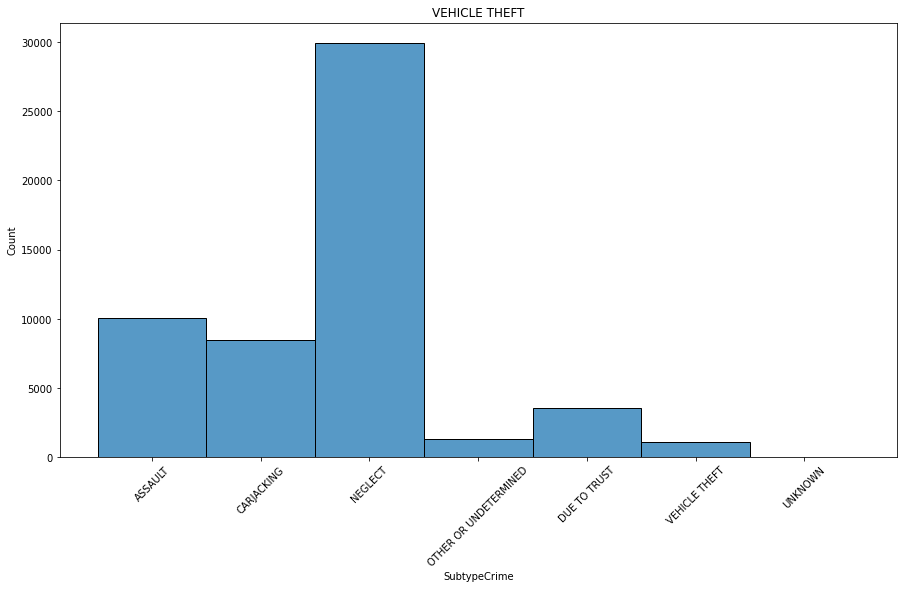

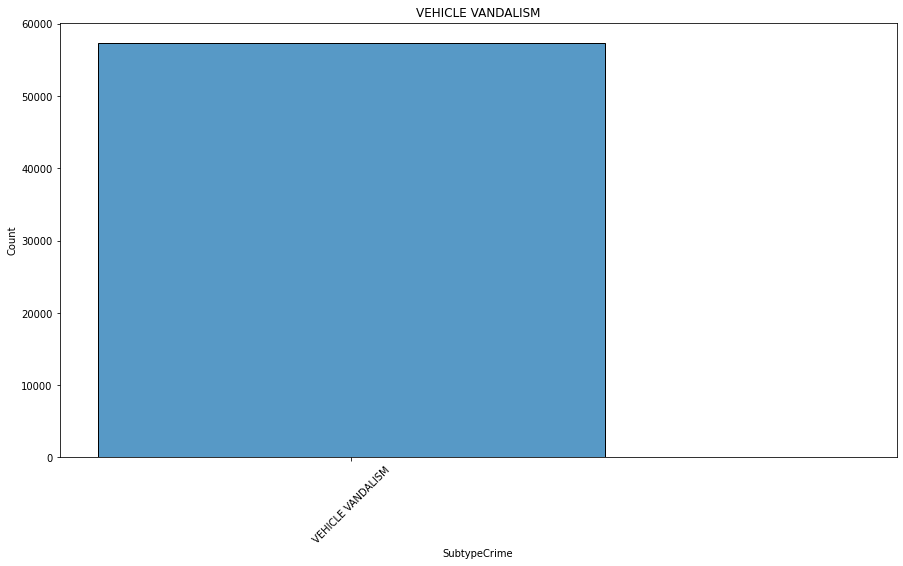

In [ ]:
#print(crimes.groupby(["Crime"])["Count"].count())

for i in crimes.Crime.unique():
  
  fig = plt.figure(figsize = (15, 8))
  sns.histplot(data = crimes[crimes.Crime == i], x = "SubtypeCrime")
  plt.title(i)
  plt.xticks(rotation = 45)

  plt.show()

Subtypes per crime are diverse. Each crime has a prevalence subtype of crime.
- Firearm for assault
- Revenge for homicide
- Due to neglect for theft and vehicle theft
- Force for robbery
- Vehicle vandalism does not have subtypes

In [ ]:
len(crimes.SubtypeVictim.unique())

94

Dataset more than 90 types of victims consequently we are going to concentrate in analysis of crimes per sex and age. Above we could find an analysis of the subcategories

##### 1.1.2. Crimes per gender


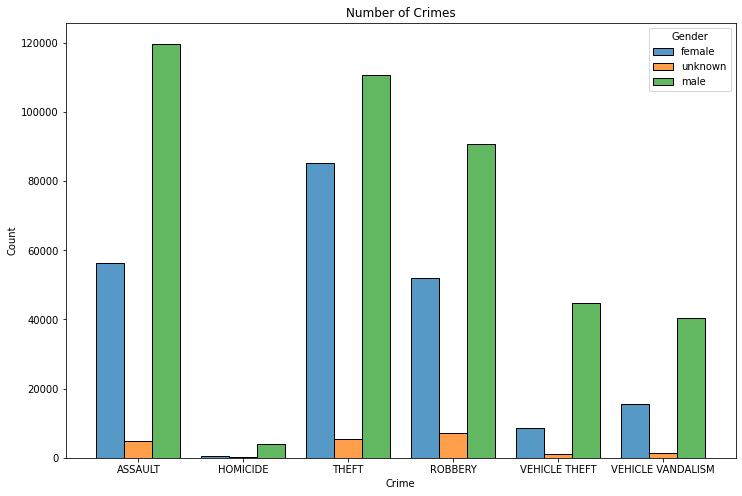

In [ ]:
fig = plt.figure(figsize = (12, 8))

sns.histplot(data = crimes, x = "Crime", hue = "Gender", 
             multiple="dodge", shrink = 0.8)

#plt.xticks(df.Crime)
plt.title("Number of Crimes")
#plt.savefig("Trips_day.png")
plt.show()
fig.savefig("Number_crimes_per_gender_general", dpi = 300)

In general, male people suffer more crimes than female, especially related to homicide (9:1 ratio) and vehicle theft (5:1 ratio). However, we can not determinante if this trend is equal in all the subcategories consequently we re going to check for more prevalence among womens in next sections

##### 1.1.3. Crimes per Age

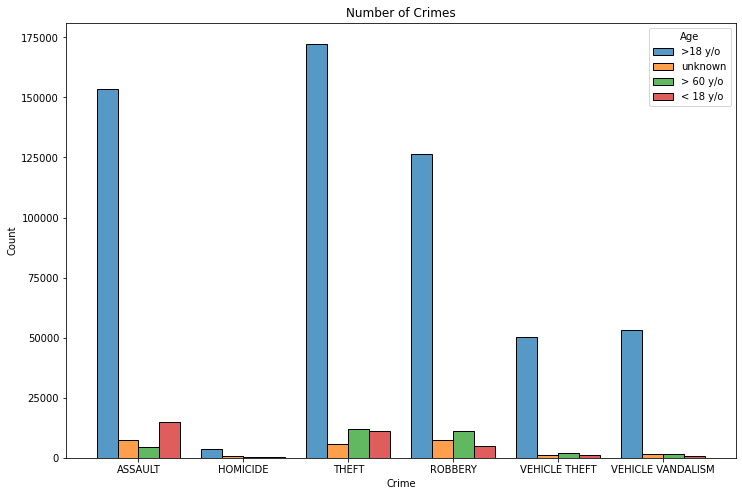

In [ ]:
fig = plt.figure(figsize = (12, 8))

sns.histplot(data = crimes, x = "Crime", hue = "Age", 
             multiple="dodge", shrink = 0.8)

#plt.xticks(df.Crime)
plt.title("Number of Crimes")
#plt.savefig("Trips_day.png")
plt.show()
fig.savefig("Number_crimes_per_age_general", dpi = 300)

Crimes per age group follow a similar percentages compared to the total population per age. Most of the crimes are in the >18 y/o group meanwhile < 18 y/o and > 60 y/o group have similar number in crimes per type.


##### 1.1.4. Crimes per hour, day, and year

Now we are going to analyse crimes per date (day of week, month and year) and hour of day.

In [ ]:
from datetime import datetime

# We need to transform date to datetime in python

#We replace "." with "/"

crimes["Date"] = crimes["Date"].apply(lambda x: x.replace(".", "/"))

#Transform to datetime

crimes["Date"] = crimes["Date"].apply(lambda x: datetime.strptime(x, "%d/%m/%y"))

# We add the year, month, and day to analyse

crimes["year"] = [x.year for x in crimes.Date]
crimes["month"] = [x.strftime("%B") for x in crimes.Date]
crimes["weekday_str"] = [x.strftime("%A") for x in crimes.Date]
crimes["weekday"] = [x.weekday() for x in crimes.Date]

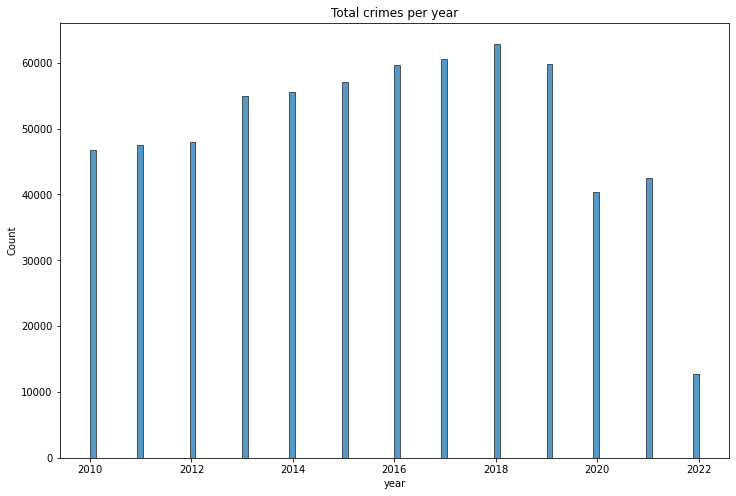

In [ ]:
fig = plt.figure(figsize = (12, 8))

sns.histplot(data = crimes, x = "year")
plt.title("Total crimes per year")

fig.savefig("Number_crimes_per_year_general", dpi = 300)

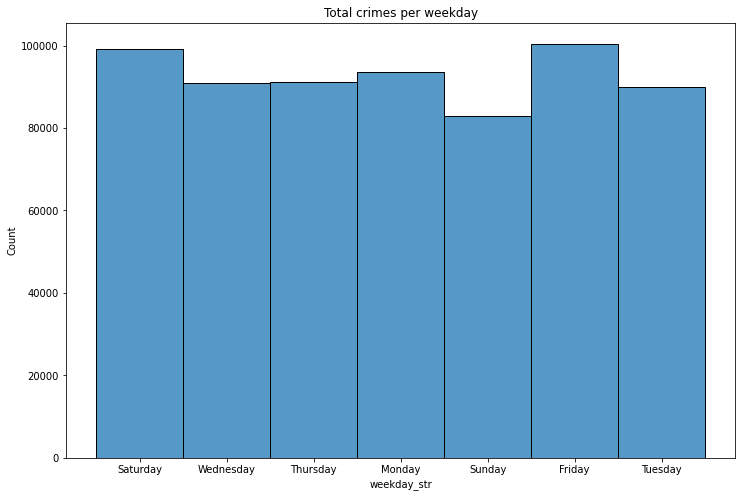

In [ ]:
fig = plt.figure(figsize = (12, 8))

sns.histplot(data = crimes, x = "weekday_str")
plt.title("Total crimes per weekday")
fig.savefig("Number_crimes_per_day_general", dpi = 300)

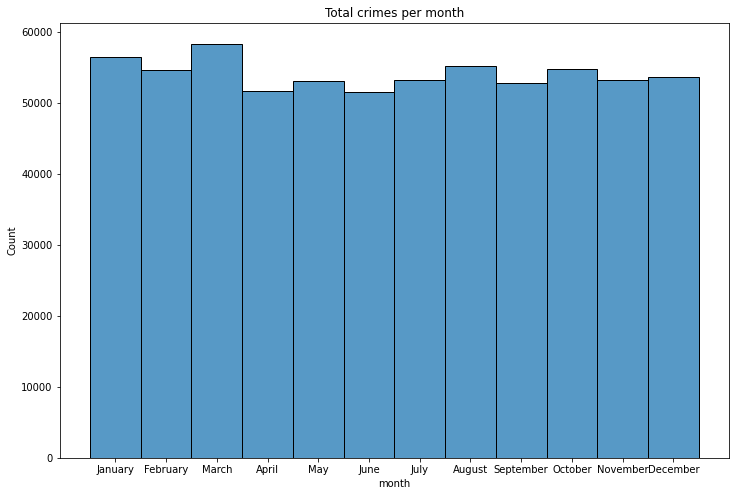

In [ ]:
fig = plt.figure(figsize = (12, 8))

sns.histplot(data = crimes, x = "month")
plt.title("Total crimes per month")

fig.savefig("Number_crimes_per_month_general", dpi = 300)

This analysis shows trends in the behaviour of the number of crimes. Firstly, an increase in the total number of crimes per year is observed between 2010 and 2018 when a decrease starts. Total numbers in 2020 could be affected because of Covid-19 pandemic, however in 2021 the total number are not very different to the previous year. On the other hand, total numbers are similar through weekday and month, Costa Rica does not have a month or day of week when crimes are higher than other.

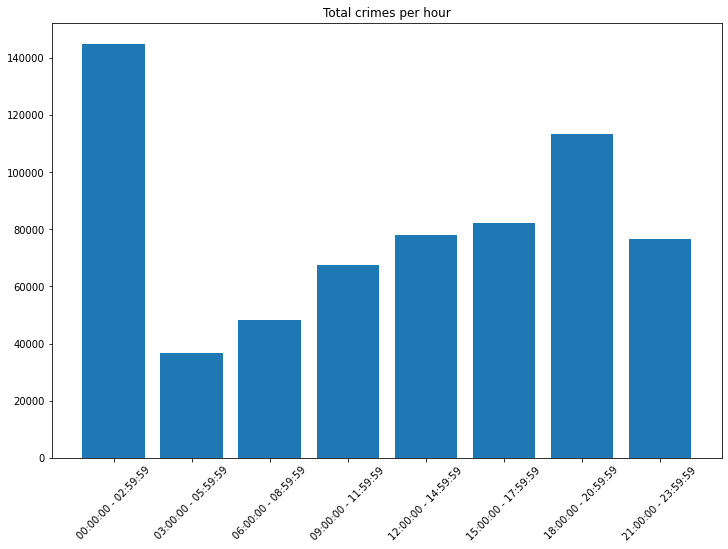

In [ ]:
df = crimes.groupby(["Time"])["Count"].count().reset_index()
fig = plt.figure(figsize = (12, 8))

df = crimes.groupby(["Time"])["Count"].count().reset_index()

plt.bar(df.Time, df.Count)
plt.title("Total crimes per hour")
plt.xticks(rotation = 45)

fig.savefig("Number_crimes_per_hour_general", dpi = 300)

Most of the crimes happened betwee 12 and 3 am in the night, besides the crimes begin to increse from 3 am up to 6 pm when a peak is showed.

##### 1.1.5. Subcategory Analysis

We identify more than 90 subcategories in the dataset. In general, crimes ratios are higher for male than females consequently we want to check if some categories are more dangerous for females

First we identify unimportant subcategories in the analysis and droped.

Now, we are going to analyse how many events are in the dataset

In [ ]:
sub_crime = crimes[~(crimes.SubtypeCrime.isin(['DECEIT/DISTRACTION',
                                                  'PICKPOCKETING',
                                                  'WITH A WRENCH',
                                                  'DUE TO TRUST',
                                                  'OTHER OR UNDETERMINED',
                                                  'DUE TO NEGLECT',
                                                  'PROGRESSIVE THEFTS DURING THE DAY',
                                                  'UNKNOWN',
                                                  'PICKLOCK',
                                                  'BREAKING AND ENTRY']))]

In [ ]:
# We list subcategories crimes

SubCrimeList= pd.unique(sub_crime.SubtypeCrime[~(sub_crime.SubtypeCrime.isna())])

# Divide the crimes per sex

female_crimes = sub_crime[sub_crime.Gender.isin(['female', 'unknown'])]
male_crimes = sub_crime[~(sub_crime.Gender.isin(['female', 'unknown']))]

#We create a dictionary with the proportion of crimes for female

dict_crime_gender = {'subCrime':[],'female_proportion':[]}

for i in SubCrimeList:
  nFemale = len(female_crimes[female_crimes.SubtypeCrime==i])
  nMale = len(male_crimes[male_crimes.SubtypeCrime==i])
  
  dict_crime_gender['subCrime'].append(i)
  dict_crime_gender['female_proportion'].append(nFemale/(nFemale+nMale))

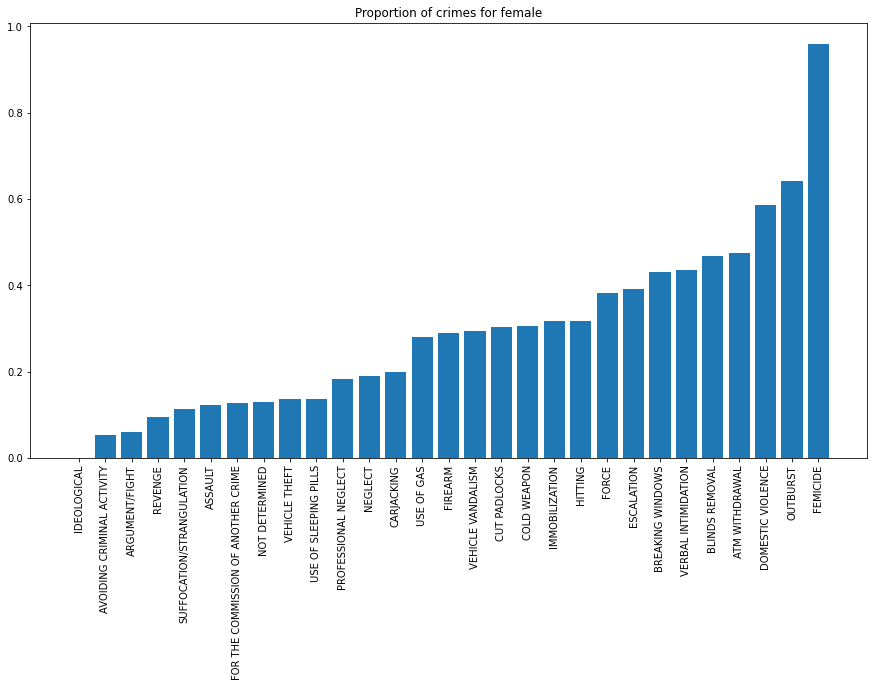

In [ ]:
fig = plt.figure(figsize = (15, 8))

df_female_crime = pd.DataFrame.from_dict(dict_crime_gender).sort_values(by='female_proportion')

plt.bar(df_female_crime.subCrime, df_female_crime.female_proportion)
plt.title("Proportion of crimes for female")
plt.xticks(rotation = 90)

plt.show()

fig.savefig("Proportion_crimes_for_female", dpi = 300)

We could identify some crimes categories that has more proportion of female than male, e.g, outburst (64%), feminicide (96%), and domestic violence (59%). We will generate a gender crime if it is higher than the mean of female proportion plus half of standard deviation

In [ ]:
n = df_female_crime.female_proportion.mean()+df_female_crime.female_proportion.std()/2
list_crimes_females = (df_female_crime[df_female_crime.female_proportion>n]).subCrime.to_list()
print(list_crimes_females)

['BREAKING WINDOWS', 'VERBAL INTIMIDATION', 'BLINDS REMOVAL', 'ATM WITHDRAWAL', 'DOMESTIC VIOLENCE', 'OUTBURST', 'FEMICIDE']


We will generate a gender crime if it is higher than the mean of female proportion plus half of standard deviation. We obtain six crimes subcategories where the gender is an important issue. With those we are going to conduct a deeper analysis considering age and time and females

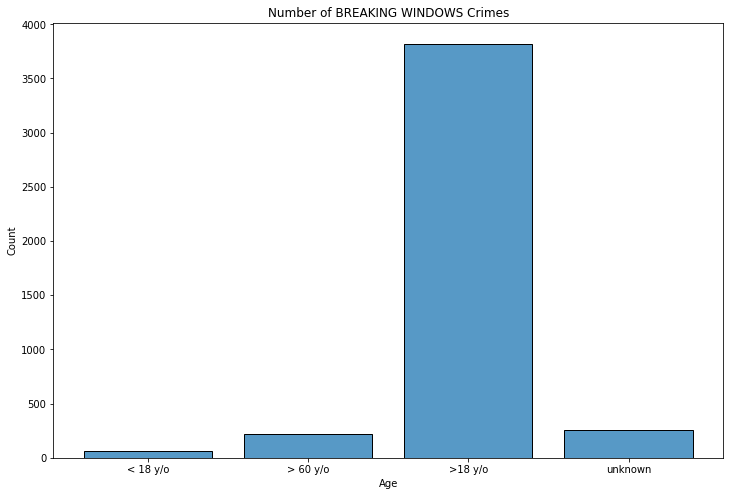

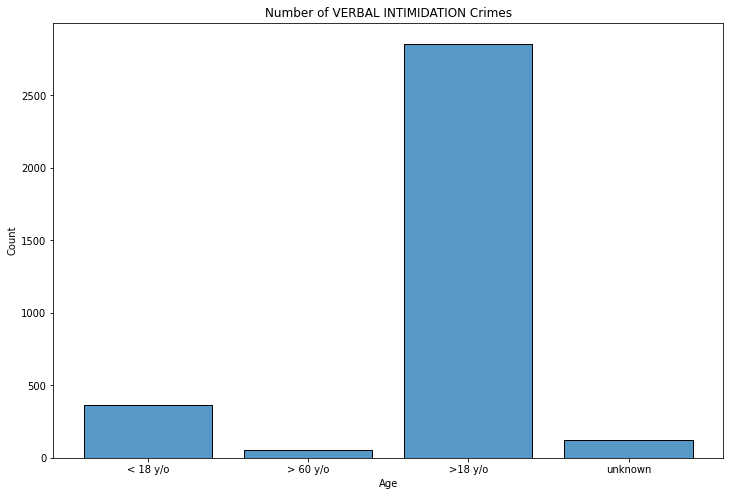

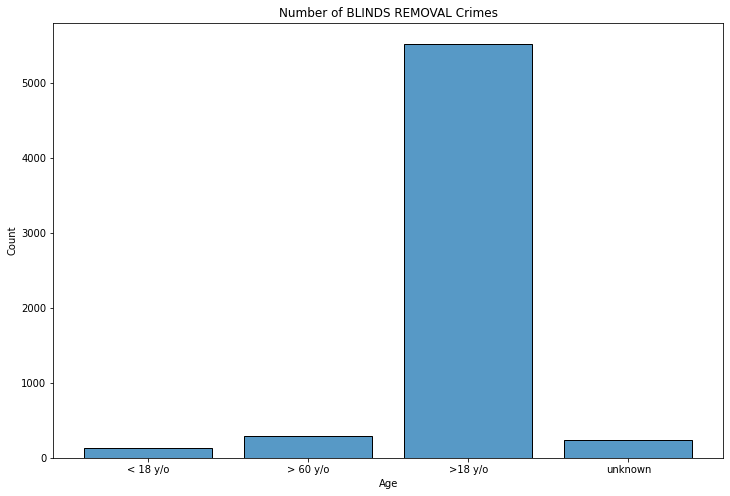

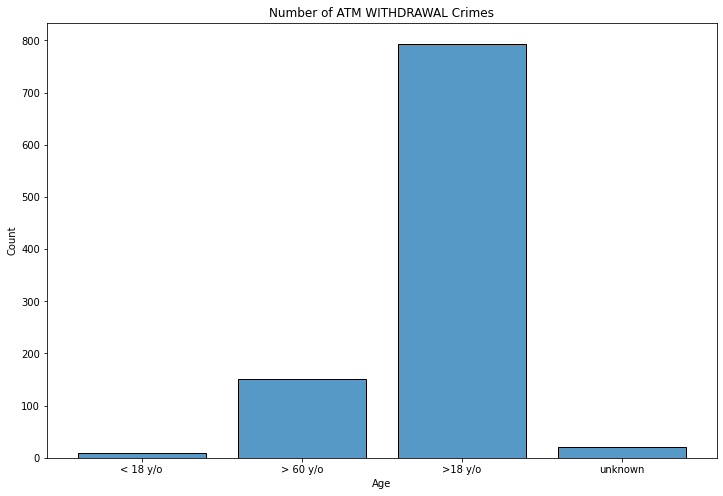

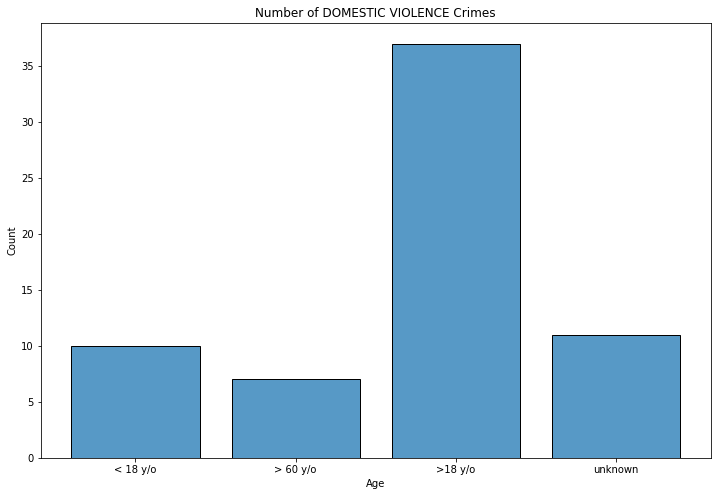

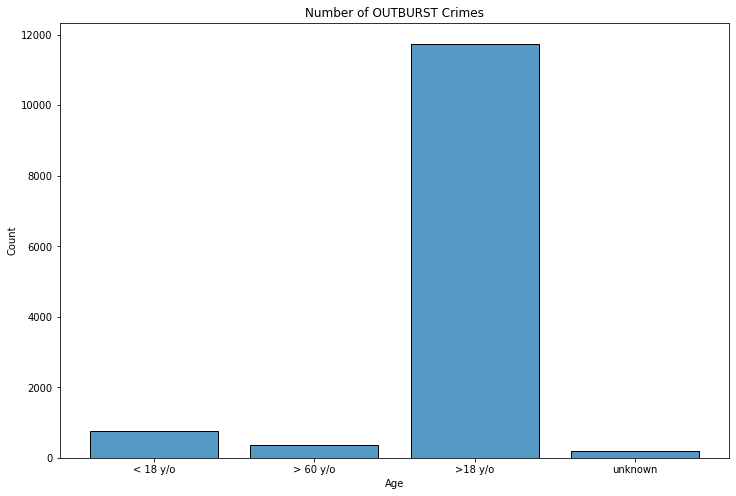

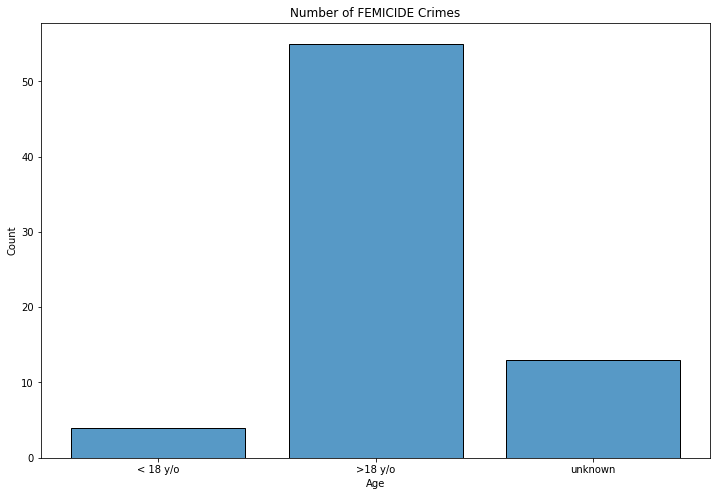

In [ ]:
for i in list_crimes_females:

  df = crimes[(crimes.SubtypeCrime.isin([i])) &
              (crimes.Gender.isin(['female', 'unknown']))].sort_values(by = "Age")


  fig = plt.figure(figsize = (12, 8))

  sns.histplot(data = df, x = "Age", 
              multiple="dodge", shrink = 0.8)

  #plt.xticks(df.Crime)
  plt.title("Number of {} Crimes".format(i))
  #plt.savefig("Trips_day.png")
  plt.show()

The analysis of female crimes per age shows than most of them are against female within 18 and 60 while BLINDS REMOVAL and ATM WITHDRAWL has more prevalence within females on ages above 60 compare with OUTBURST, DOMESTIC VIOLENCE, and VERBAL INTIMIDATION that has more case within female below 18 years than above 60 years. Finally,, femicide is not presented among female above 60 years.

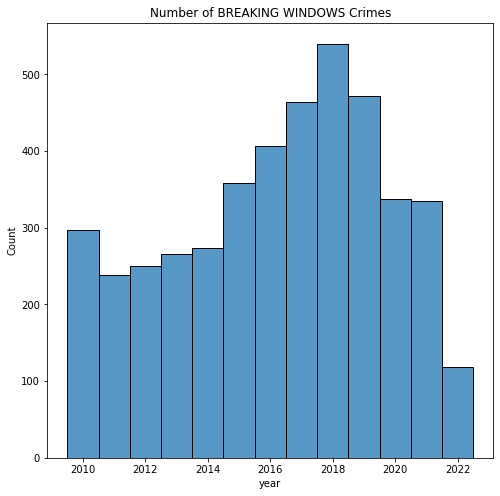

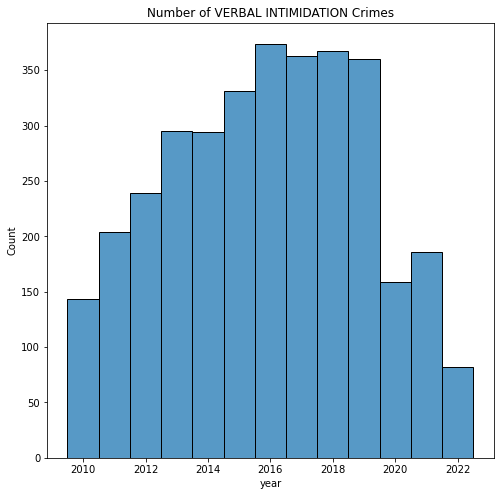

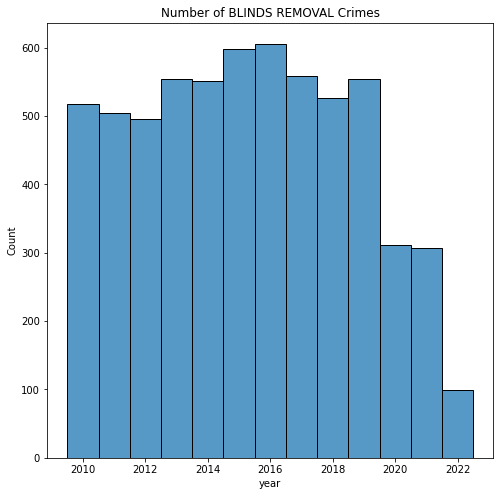

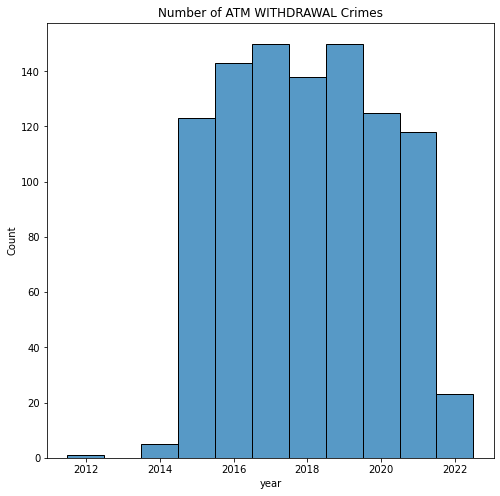

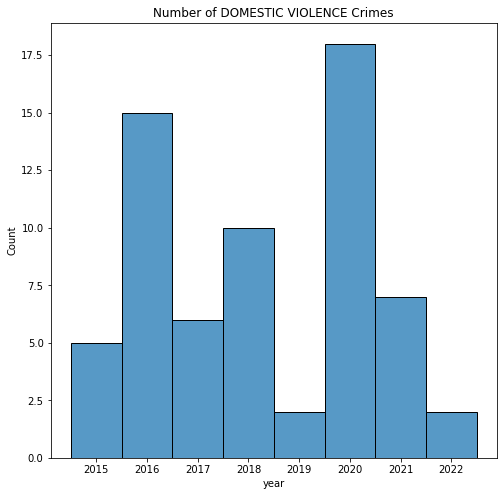

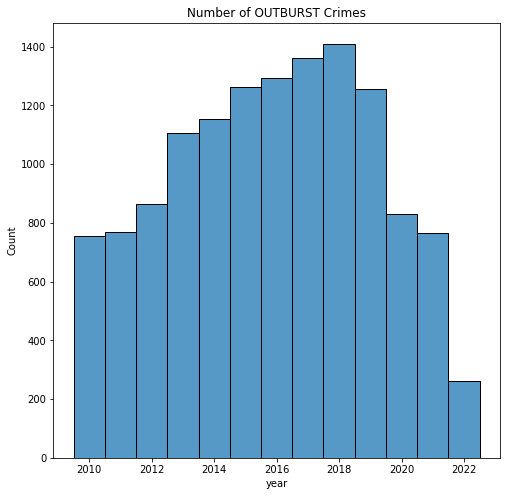

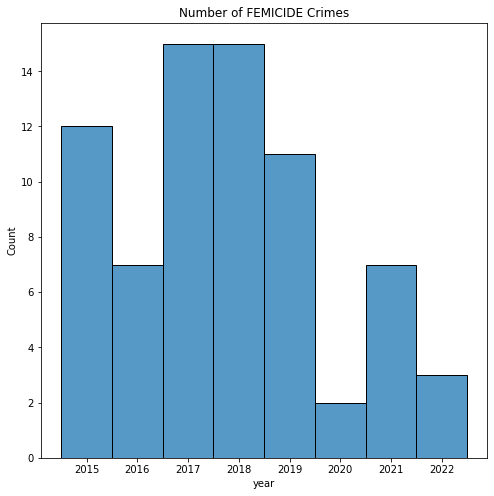

In [ ]:
for i in list_crimes_females:

  df = crimes[(crimes.SubtypeCrime.isin([i])) &
              (crimes.Gender.isin(['female', 'unknown']))]


  fig = plt.figure(figsize = (8, 8))

  sns.histplot(data = df, x = "year", discrete=True)

  #plt.xticks(df.Crime)
  plt.title("Number of {} Crimes".format(i))
  #plt.savefig("Trips_day.png")
  plt.show()

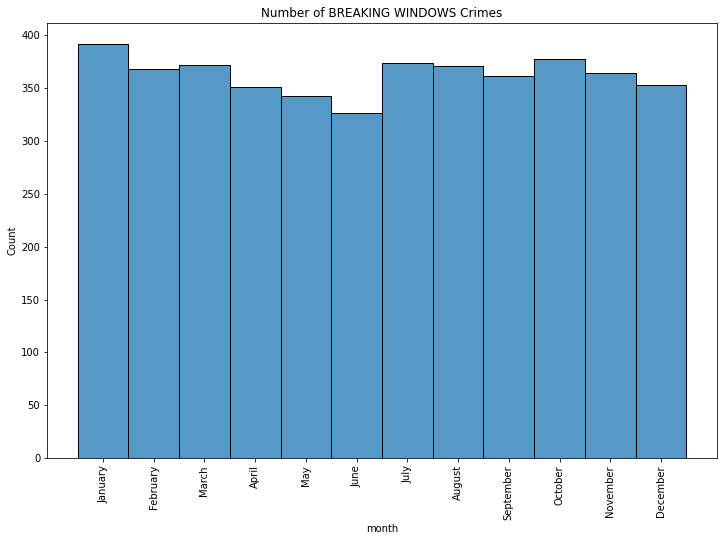

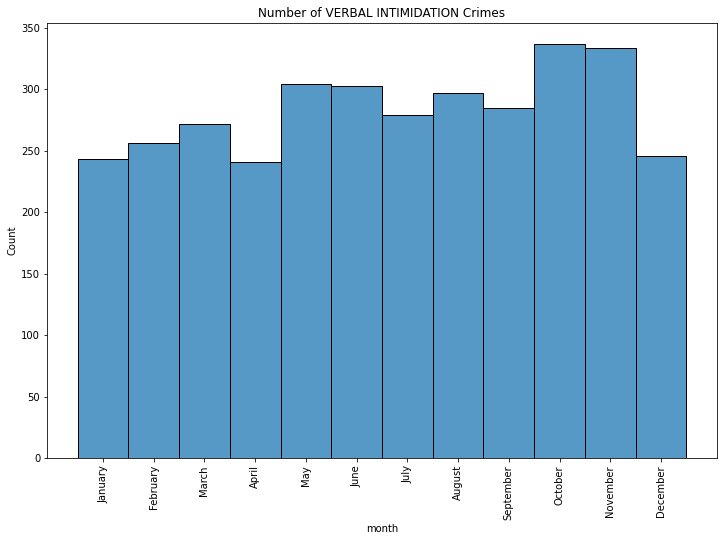

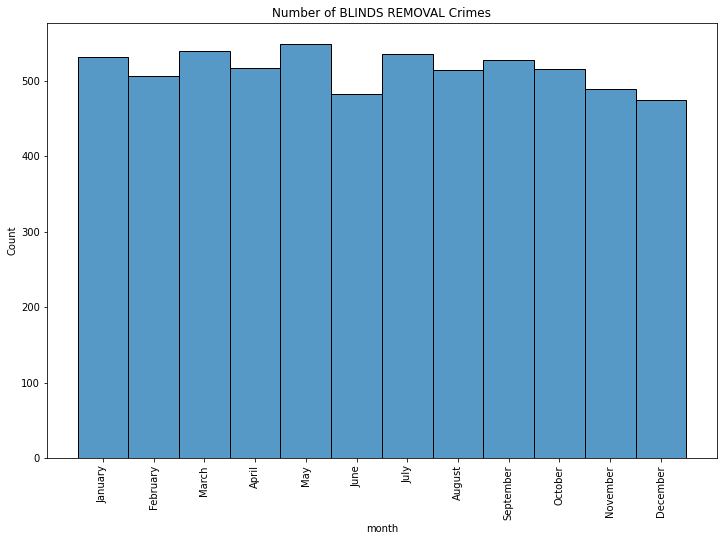

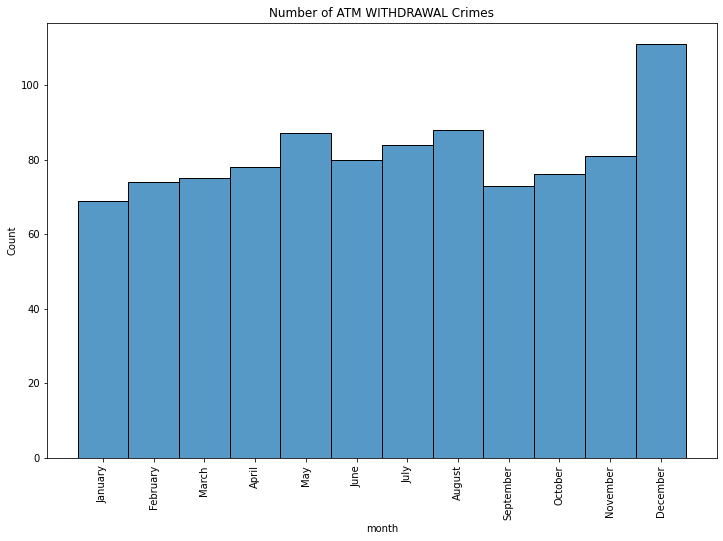

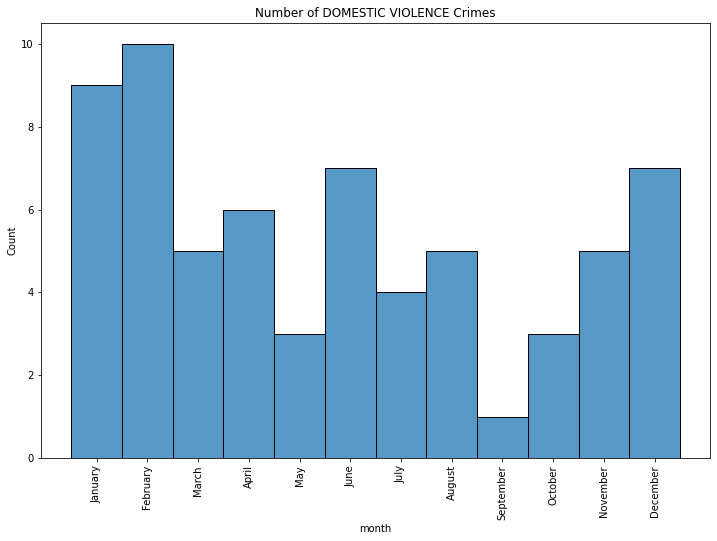

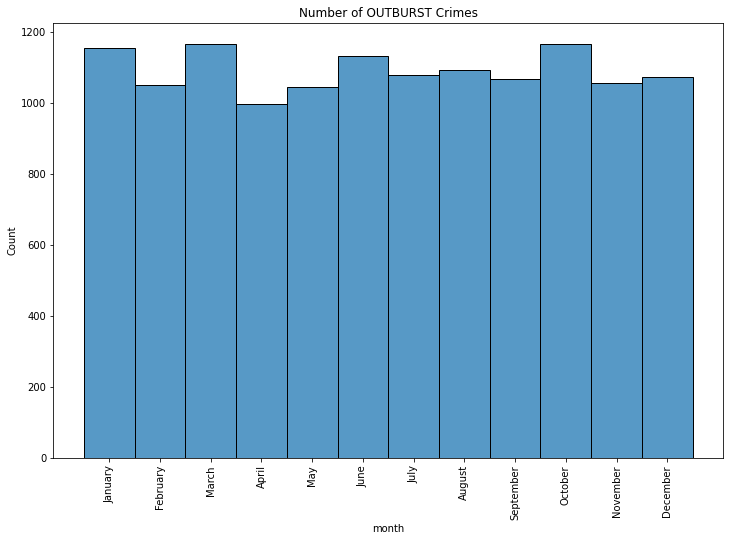

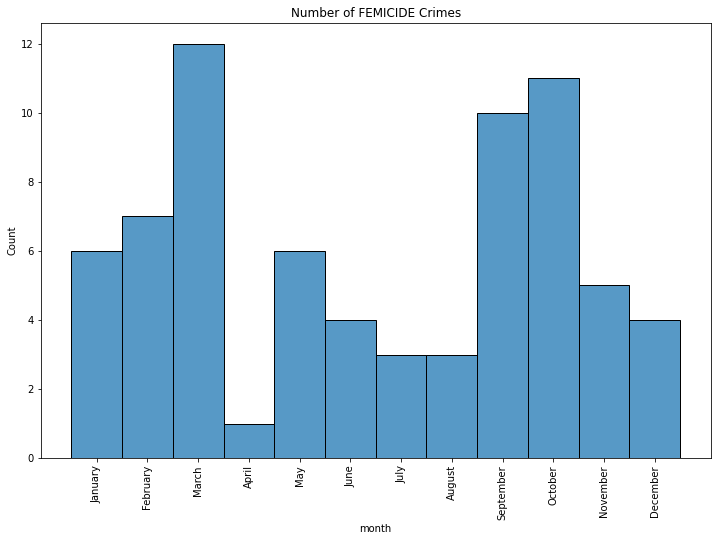

In [ ]:
for i in list_crimes_females:

  cat_size_order = CategoricalDtype(
    ["January", "February", "March", "April", "May", "June",
     "July", "August", "September", "October", "November", "December"], ordered=True)
  
  df = crimes[(crimes.SubtypeCrime.isin([i])) &
              (crimes.Gender.isin(['female', 'unknown']))]

  
  df["month"] = df["month"].astype(cat_size_order)

  df = df.sort_values(by = "month")

  fig = plt.figure(figsize = (12, 8))

  sns.histplot(data = df, x = "month", discrete=True)

  #plt.xticks(df.Crime)
  plt.title("Number of {} Crimes".format(i))
  plt.xticks(rotation = 90)
  plt.show()

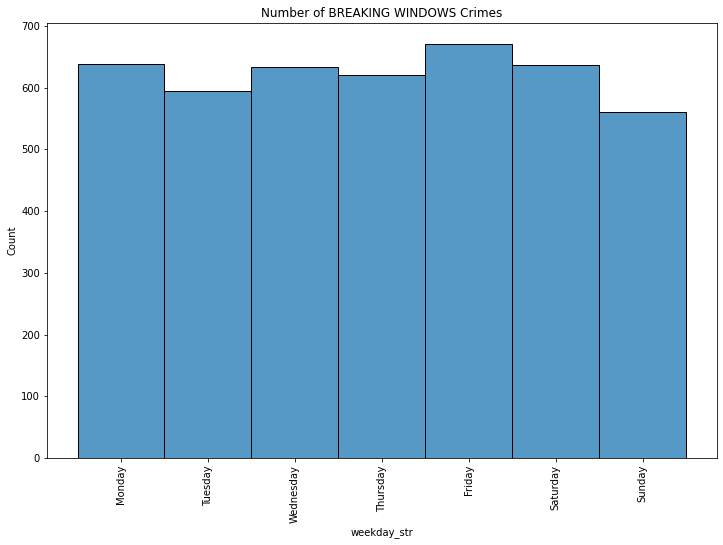

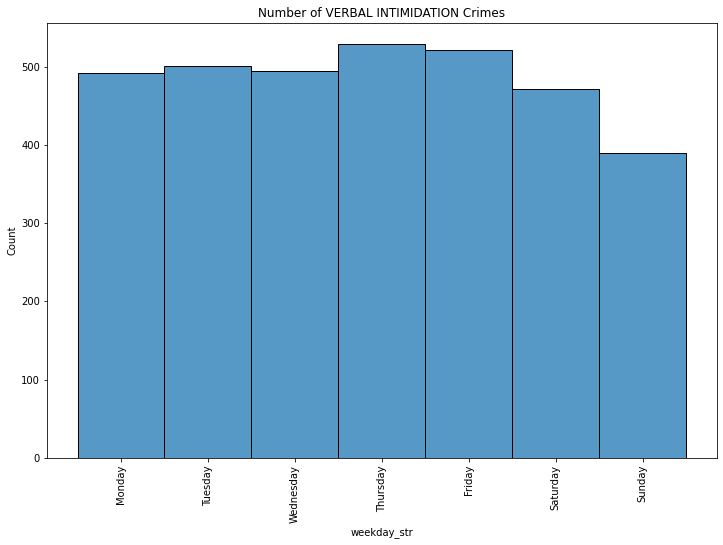

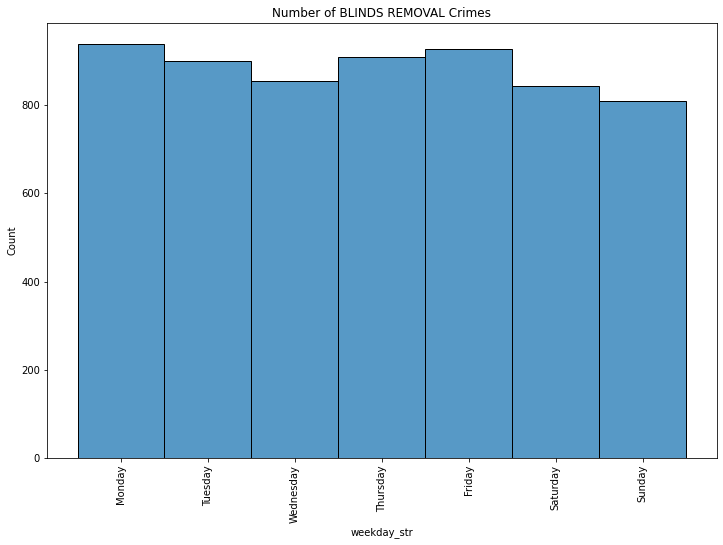

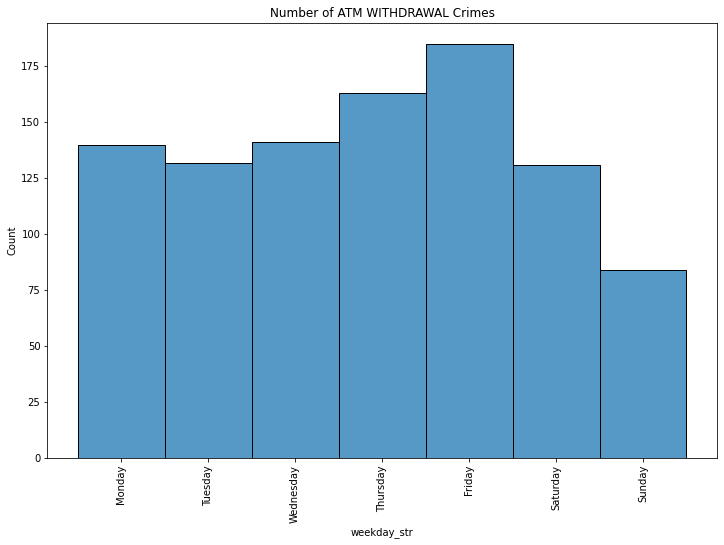

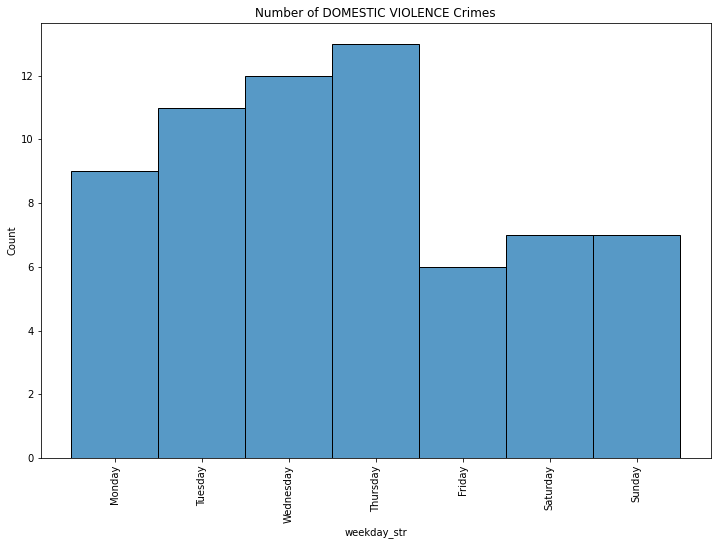

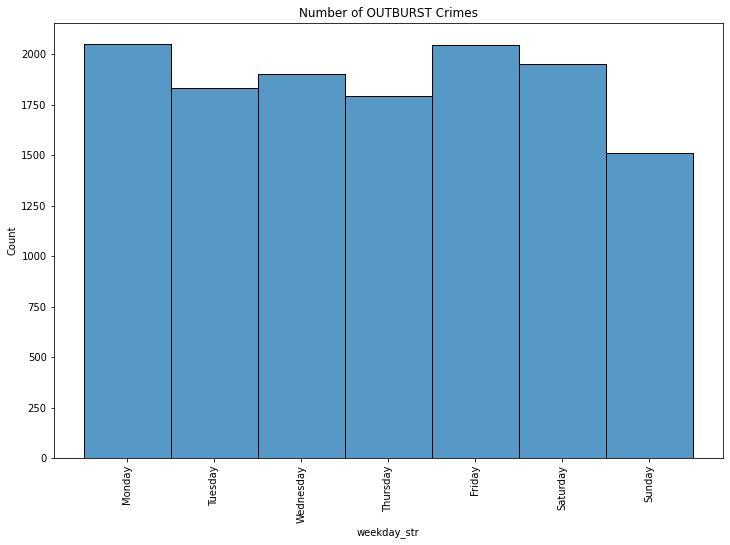

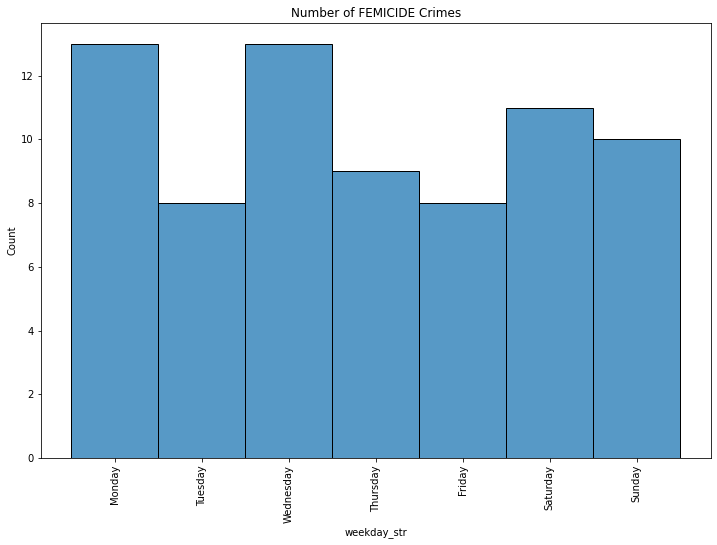

In [ ]:
for i in list_crimes_females:

  cat_size_order = CategoricalDtype(
    ["Monday", "Tuesday", "Wednesday", "Thursday",
            "Friday", "Saturday", "Sunday"], ordered=True)
  
  df = crimes[(crimes.SubtypeCrime.isin([i])) &
              (crimes.Gender.isin(['female', 'unknown']))]
  
  df["weekday_str"] = df["weekday_str"].astype(cat_size_order)
                                               
  df = df.sort_values(by = "weekday_str")


  fig = plt.figure(figsize = (12, 8))

  sns.histplot(data = df, x = "weekday_str", discrete=True)

  #plt.xticks(df.Crime)
  plt.title("Number of {} Crimes".format(i))
  plt.xticks(rotation = 90)
  plt.show()

This analysis shows trends in the behaviour of the number of female crimes. Firstly, some crimes shows similar trends that the general ones; however, some of them like feminicide or domestic violence do not show trends related to years, they have an irregular behaviour through the years. Furthermore, an increase of domestic violence crimes during 2020 is show, they could be explained because of the pandemic and lockdowns. Those behaviours in the trends are similar in the analysis per month where feminicide and domestic violence does not show similar trends in the months such us the other subcategories. January and February have higher cases of domestic violence than other months while March, September and October are critical months for Feminicides. Finally, the analysis per day shows that crimes decrease during the weekend; ATM WITHDRAWL increase friday and DOMESTIC VIOLENCE has an increase trend between monday and thursday when a peak is shown. Finally, most of the FEMINICIDES happened on monday or wednesday.


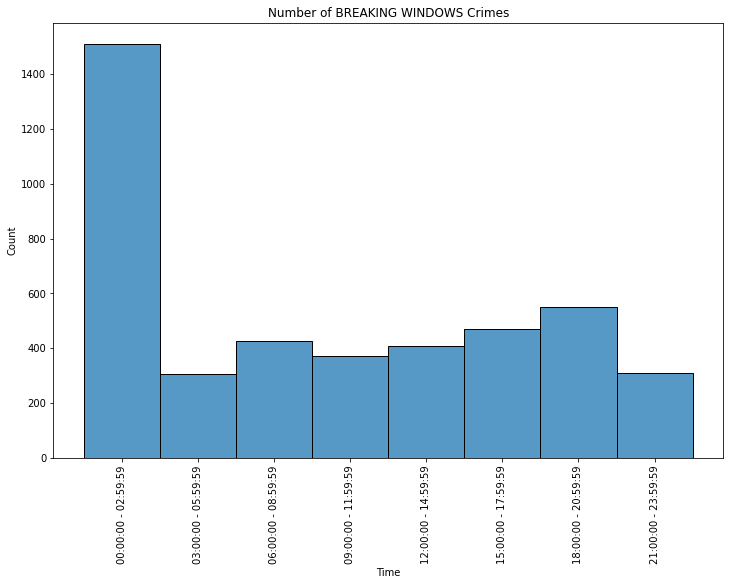

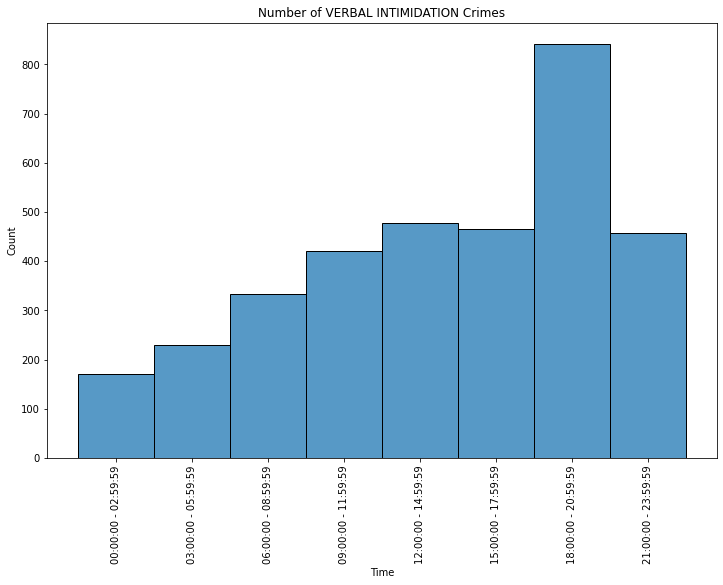

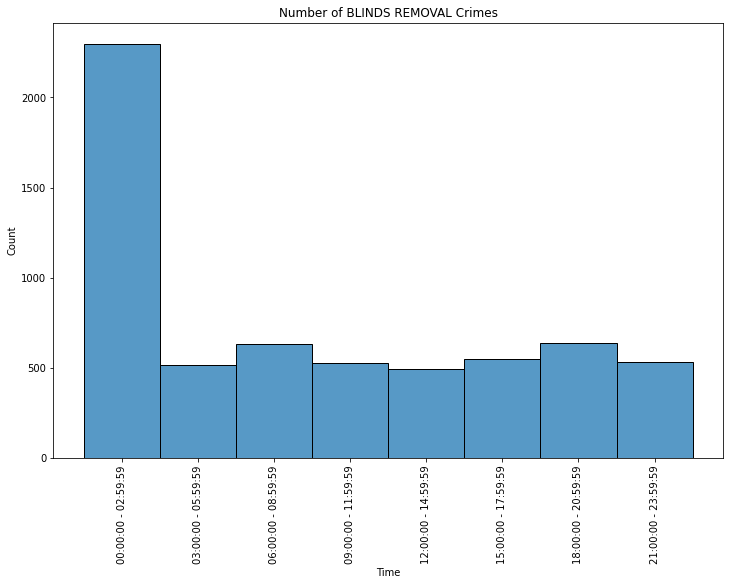

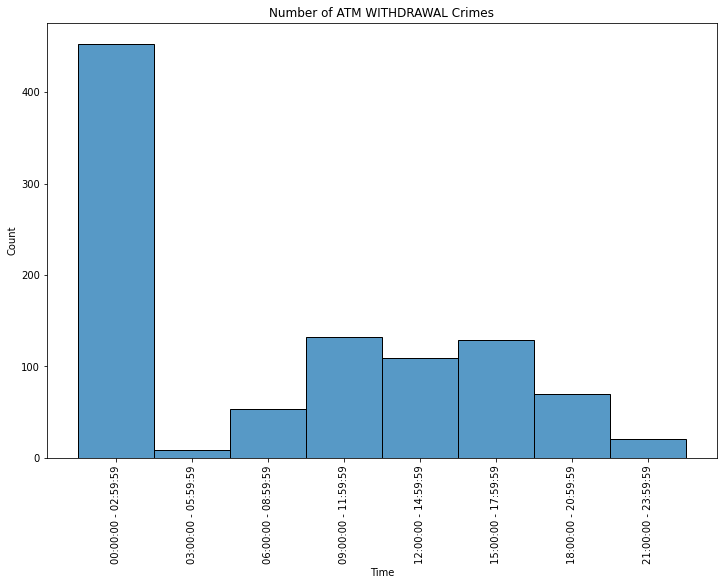

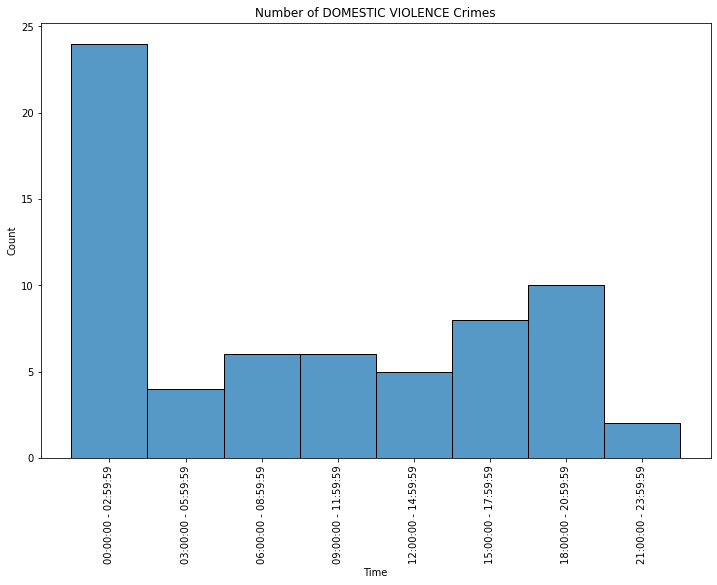

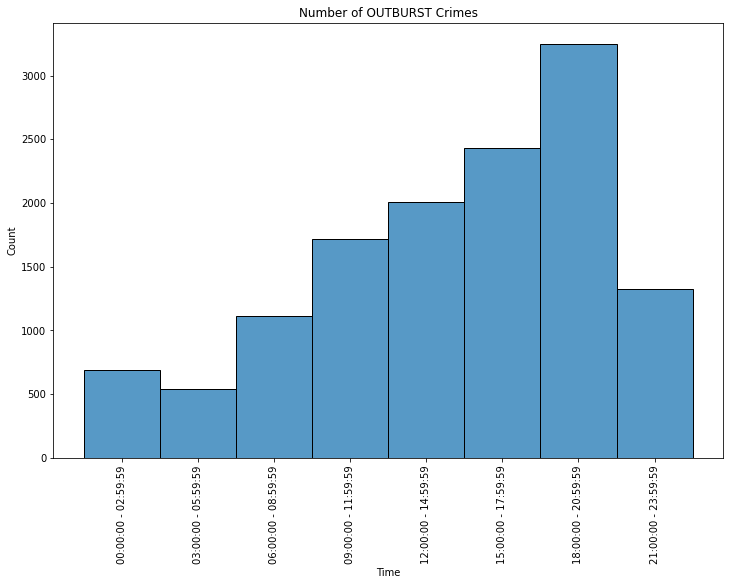

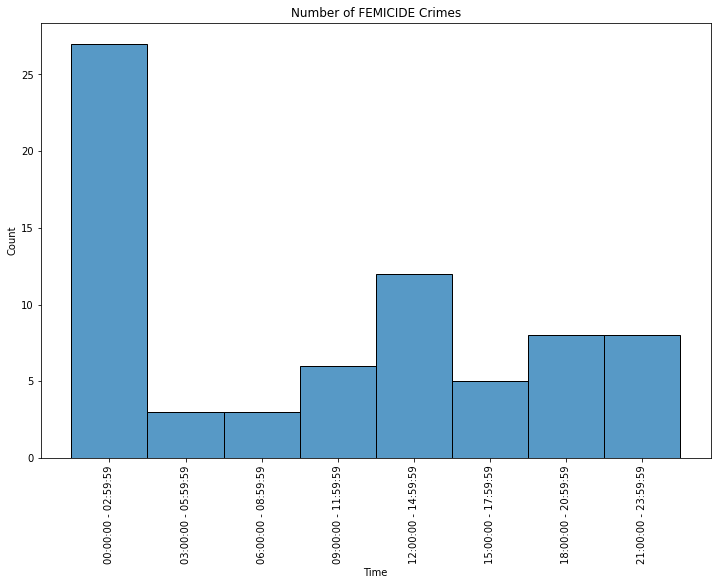

In [ ]:
for i in list_crimes_females:

  cat_size_order = CategoricalDtype(
    ['00:00:00 - 02:59:59', '03:00:00 - 05:59:59', '06:00:00 - 08:59:59',
     '09:00:00 - 11:59:59', '12:00:00 - 14:59:59', '15:00:00 - 17:59:59',
      '18:00:00 - 20:59:59', '21:00:00 - 23:59:59'], ordered=True)
  
  df = crimes[(crimes.SubtypeCrime.isin([i])) &
              (crimes.Gender.isin(['female', 'unknown']))]
  
  df["Time"] = df["Time"].astype(cat_size_order)
                                               
  df = df.sort_values(by = "Time")


  fig = plt.figure(figsize = (12, 8))

  sns.histplot(data = df, x = "Time", discrete=True)

  #plt.xticks(df.Crime)
  plt.title("Number of {} Crimes".format(i))
  plt.xticks(rotation = 90)
  plt.show()

The time analysis shows important trends per crime subcategory. Feminicide, Domestic Violence, ATM withdrawal, blinds removal, and breaking windows are higher within 12 and 3 am meanwhile verbal intimidation and outburst has their peak between 6 and 9 pm

##### 1.1.6. Crimes per Canton and District

Now we are going to analyse the data aggregate per Canton and district

In [ ]:
provinces = gpd.read_file(BASE_PATH + "urbanalytica_datasets/provinces_costarica.geojson")
canton = gpd.read_file("https://services.arcgis.com/LjCtRQt1uf8M6LGR/arcgis/rest/services/Cantones_CR/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")
district = gpd.read_file(BASE_PATH+ "urbanalytica_datasets/districts_costarica.geojson")

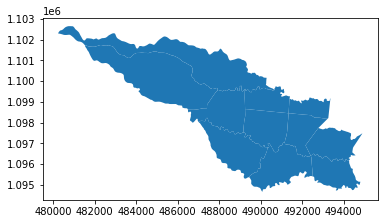

In [ ]:
district[district["NOM_CANT"] == "SAN JOSE"].plot()

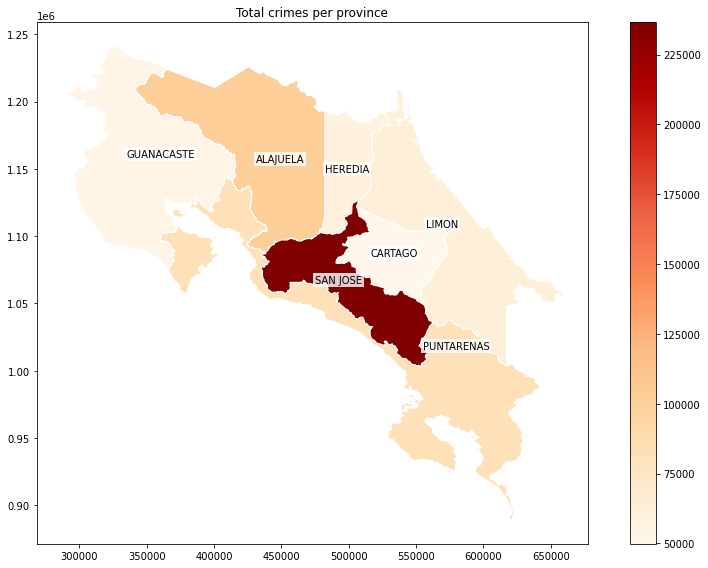

In [ ]:
# Analysis per district
provinces = pd.merge(provinces, crimes.groupby(["Province"])["Count"].count().reset_index(),
                     left_on = "NPROVINCIA", right_on = "Province", how = "left")
#For labels
provinces['coords'] = provinces['geometry'].apply(lambda x: x.representative_point().coords[:])
provinces['coords'] = [coords[0] for coords in provinces['coords']]

fig, ax = plt.subplots(figsize=(12,8))

provinces.plot(column = "Count",
               legend = True,
               edgecolor = "white",
               cmap = "OrRd",
               ax = ax)

texts =[ax.text(row.coords[0], row.coords[1], s=row["NPROVINCIA"], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}) for idx, row in provinces.iterrows()]

plt.title("Total crimes per province")
plt.tight_layout()

plt.show()

fig.savefig("Crimes_per_province_general", dpi = 300)

We can observ that most of the crimes cases are in the province of San José follow by Allahuella

Now we can perform the trips analysis considering date, hour, duration and origin-destination.

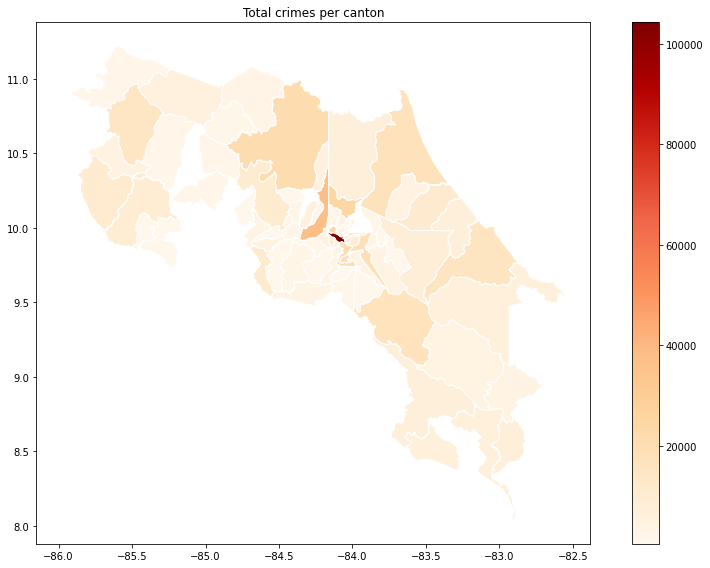

In [ ]:
#Analysis per Canton

canton = pd.merge(canton, crimes.groupby(["Canton"])["Count"].count().reset_index(),
                     left_on = "NOM_CANT_1", right_on = "Canton", how = "left")

#For labels
canton['coords'] = canton['geometry'].apply(lambda x: x.representative_point().coords[:])
canton['coords'] = [coords[0] for coords in canton['coords']]

fig, ax = plt.subplots(figsize=(12,8))

canton[canton.NOM_CANT_1 != "PUNTARENAS"].plot(column = "Count",
               legend = True,
               edgecolor = "white",
               cmap = "OrRd",
               ax = ax)

#texts =[ax.text(row.coords[0], row.coords[1], s=row["NOM_CANT_1"], horizontalalignment='center', bbox={'facecolor': 'white', 
 #                                                                                                      'alpha':0.2, 'pad': 2, 
  #                                                                                                     'edgecolor':'none'}) for idx, row in canton.iterrows()]

plt.title("Total crimes per canton")
plt.tight_layout()

plt.show()

fig.savefig("Crimes_per_canton_general", dpi = 300)

We observe that San Jose canton regiters higher rates of crimes compared with the rest of the country

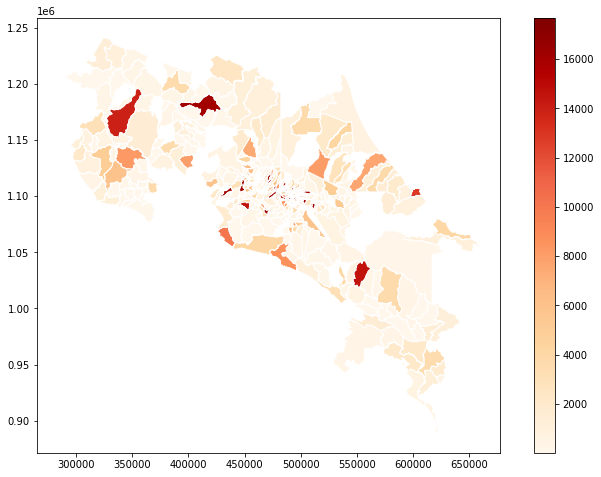

In [ ]:
#Finally per districts

district = pd.merge(district, crimes.groupby(["District"])["Count"].count().reset_index(),
                     left_on = "NOM_DIST", right_on = "District", how = "left")

fig, ax = plt.subplots(figsize=(12,8))

district[district.NOM_CANT != "PUNTARENAS"].plot(column = "Count",
               legend = True,
               edgecolor = "white",
               cmap = "OrRd",
               ax = ax)

fig.savefig("Crimes_per_district_general", dpi = 300)

The district analysis is more refined, consequently we observe a different behaviour in the number of crimes, e.g., more red polygons appear in the country showing other districts with higher rates of crimes besides of the capital. We are going to continue the analysis at this resolution level because is more accurate.

#### 1.2 Sexual harassment dataset

##### 1.2.1. General analysis

In [ ]:
sex_har["province"] = sex_har["province"].str.upper()
sex_har["canton"] = sex_har["canton"].str.upper() 
sex_har["district"] = sex_har["district"].str.upper()  

In [ ]:
sex_har.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   province                            56 non-null     object
 1   canton                              56 non-null     object
 2   district                            56 non-null     object
 3   public_prosecutors_office           56 non-null     object
 4   sexual_harassement                  56 non-null     int64 
 5   exhibitionism                       56 non-null     int64 
 6   pursuit_or_cornering                56 non-null     int64 
 7   production_of_audiovisual_material  56 non-null     int64 
 8   sexual_harassement_law              56 non-null     int64 
dtypes: int64(5), object(4)
memory usage: 4.1+ KB


In [ ]:
sex_har.describe()

sexual_harassement  exhibitionism  pursuit_or_cornering  \
count           56.000000      56.000000             56.000000   
mean             1.964286       2.321429              0.946429   
std              2.847419       2.796798              1.611545   
min              0.000000       0.000000              0.000000   
25%              0.000000       1.000000              0.000000   
50%              1.000000       1.000000              0.000000   
75%              3.000000       3.000000              1.000000   
max             14.000000      12.000000              8.000000   

       production_of_audiovisual_material  sexual_harassement_law  
count                           56.000000               56.000000  
mean                             0.410714                0.767857  
std                              0.968162                2.434532  
min                              0.000000                0.000000  
25%                              0.000000                0.000000  
50%                              0.000000                0.000000  
75%                              0.000000                0.000000  
max                              5.000000               15.000000

##### 1.2.2. Analysis per categories

In [ ]:
sex_har_counts = sex_har[['sexual_harassement', 'exhibitionism', 'pursuit_or_cornering',
       'production_of_audiovisual_material', 'sexual_harassement_law']].sum().reset_index().rename(columns = {"index" : "sex_har",
                                                                                                              0 : "Count"})

sex_har_counts

sex_har  Count
0                  sexual_harassement    110
1                       exhibitionism    130
2                pursuit_or_cornering     53
3  production_of_audiovisual_material     23
4              sexual_harassement_law     43

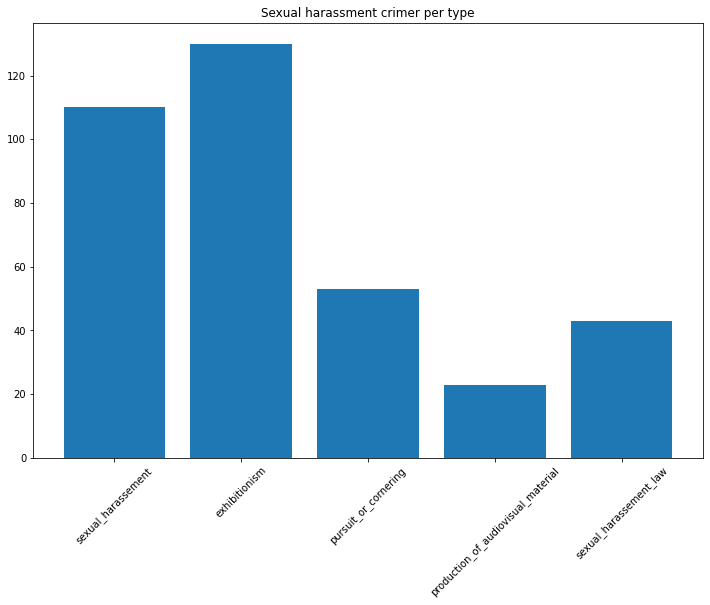

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.bar(sex_har_counts.sex_har, sex_har_counts.Count)
plt.title("Sexual harassment crimer per type")
plt.xticks(rotation = 45)

fig.savefig("Crimes_per_province_sexualharassment", dpi = 300)

We obtain general statistics of sexual harassment crimes per province, canton, and district. We do not know the time resolution of the dataset. The dataset contains 56 rows, i.e., data for 56 districts in Costa Rica. The most common sexual harassment crime is exhibitionism follow by general acts of sexual harassment.

##### 1.2.3. Analysis per district and Canton

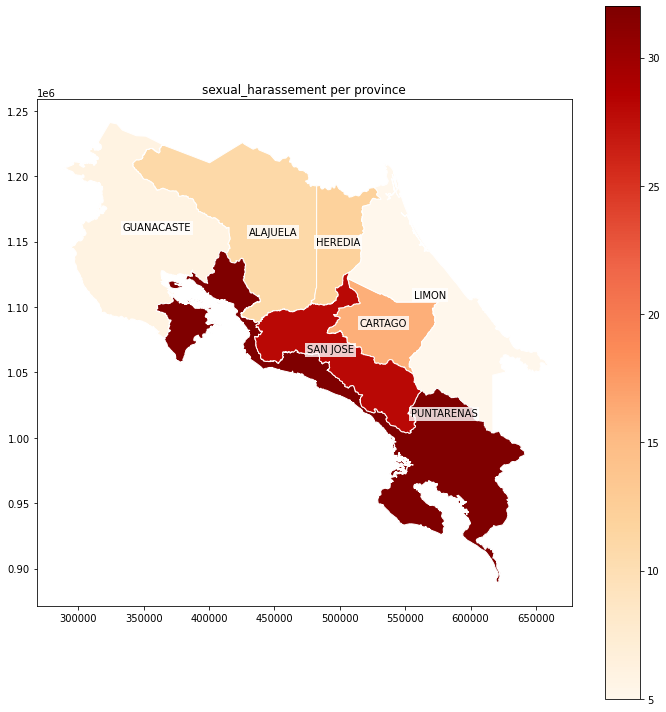

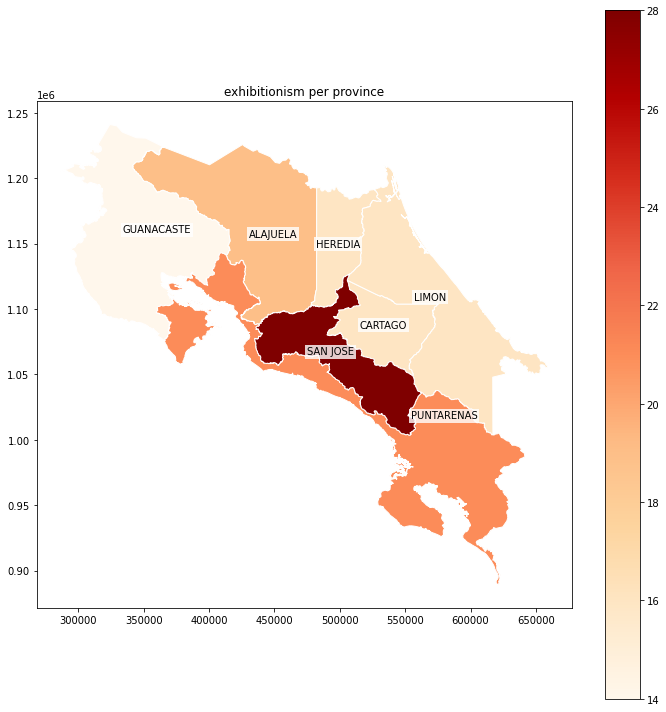

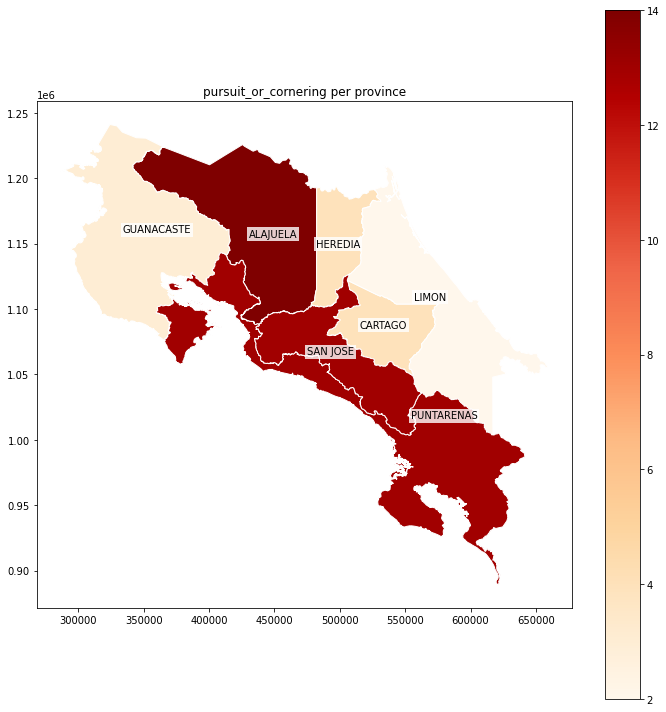

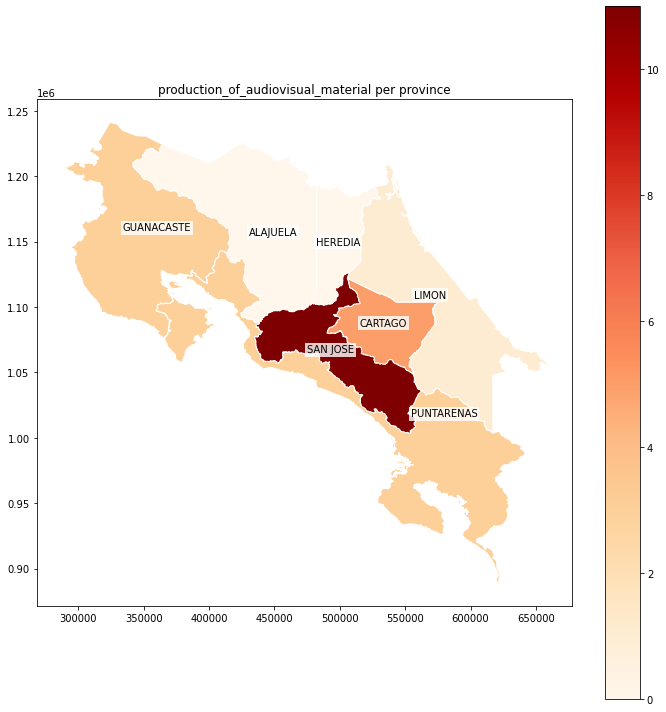

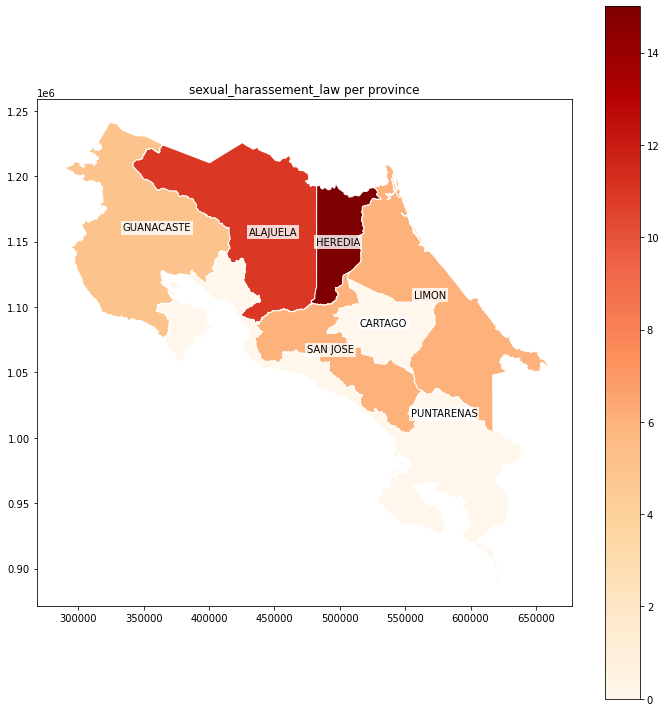

In [ ]:
types_sh = ['sexual_harassement', 'exhibitionism', 'pursuit_or_cornering',
       'production_of_audiovisual_material', 'sexual_harassement_law']

df_provinces = sex_har.groupby(["province"])[types_sh].sum().reset_index()

provinces = pd.merge(provinces, df_provinces, how = "left",
                     left_on = "NPROVINCIA", right_on = "province")

for i in types_sh:

  fig, ax = plt.subplots(figsize=(10,10))
  provinces.plot(column = i,
                legend = True,
                edgecolor = "white",
                cmap = "OrRd",
                ax = ax)

  texts =[ax.text(row.coords[0], row.coords[1], s=row["NPROVINCIA"], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}) for idx, row in provinces.iterrows()]

  plt.title("{} per province".format(i))
  plt.tight_layout()

  plt.show()

We observe differences in the distribution of sexual harassment crimes per province. Punta Arenas register the highest number of general sexual harassment, while exhibitionism and production of audiovisual material is the highest in San Jose. On the other hand, pursuit is most common in alajuela follow by other three provinces.

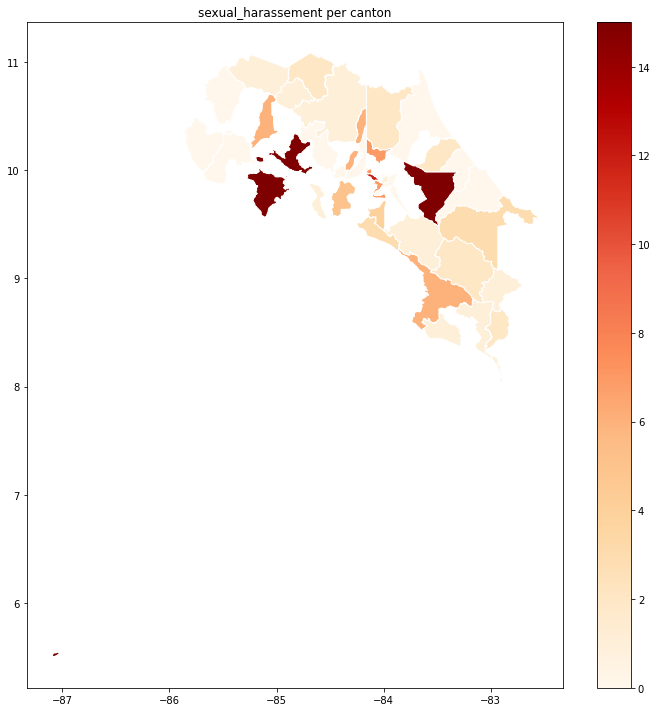

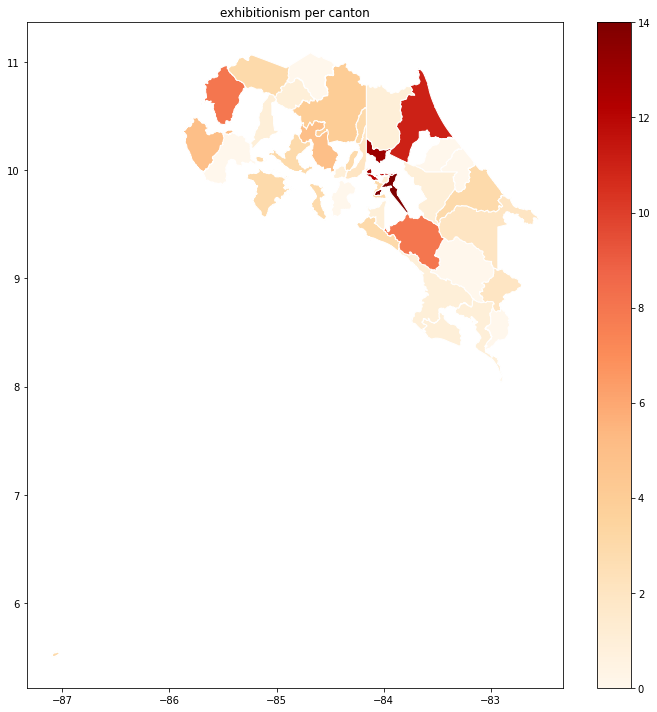

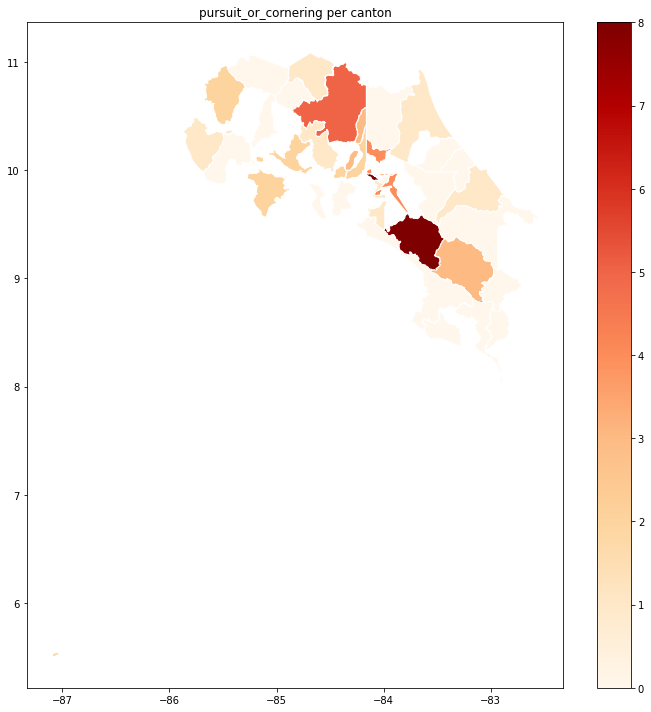

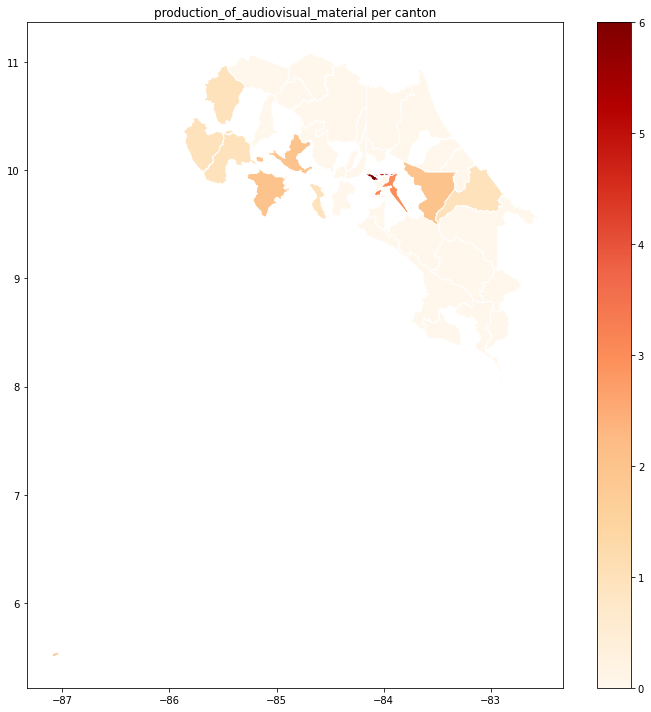

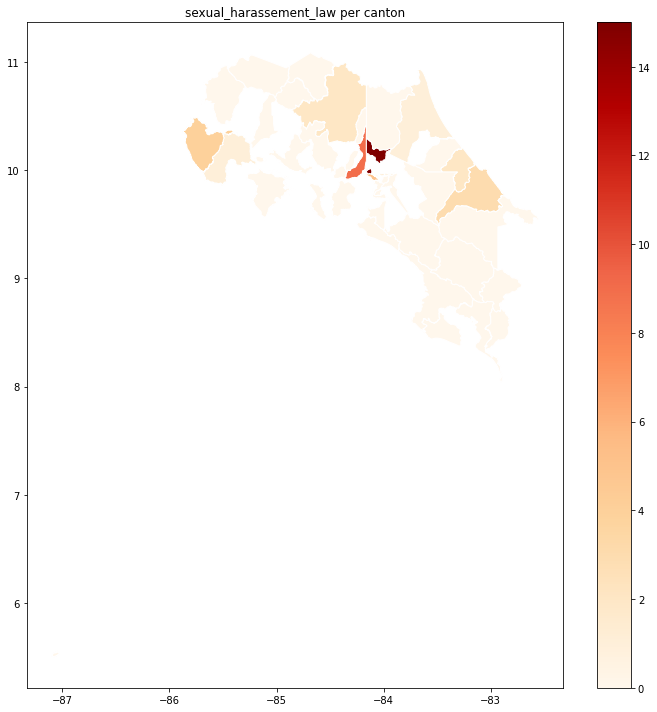

In [ ]:
df_canton = sex_har.groupby(["canton"])[types_sh].sum().reset_index()

canton = pd.merge(canton, df_canton, how = "left",
                     left_on = "NOM_CANT_1", right_on = "canton")

for i in types_sh:

  fig, ax = plt.subplots(figsize=(10,10))
  
  canton.plot(column = i,
                legend = True,
                edgecolor = "white",
                cmap = "OrRd",
                ax = ax)

  #texts =[ax.text(row.coords[0], row.coords[1], s=row["NPROVINCIA"], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}) for idx, row in provinces.iterrows()]

  plt.title("{} per canton".format(i))
  plt.tight_layout()

  plt.show()

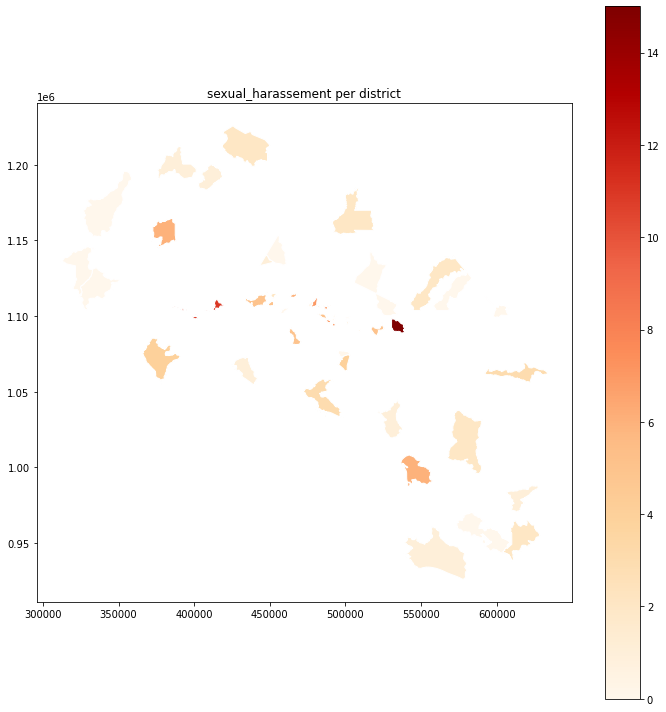

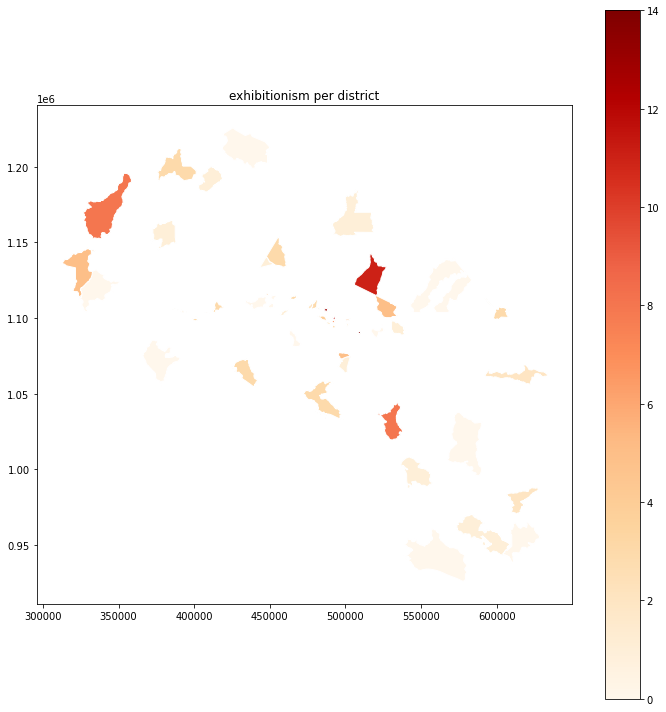

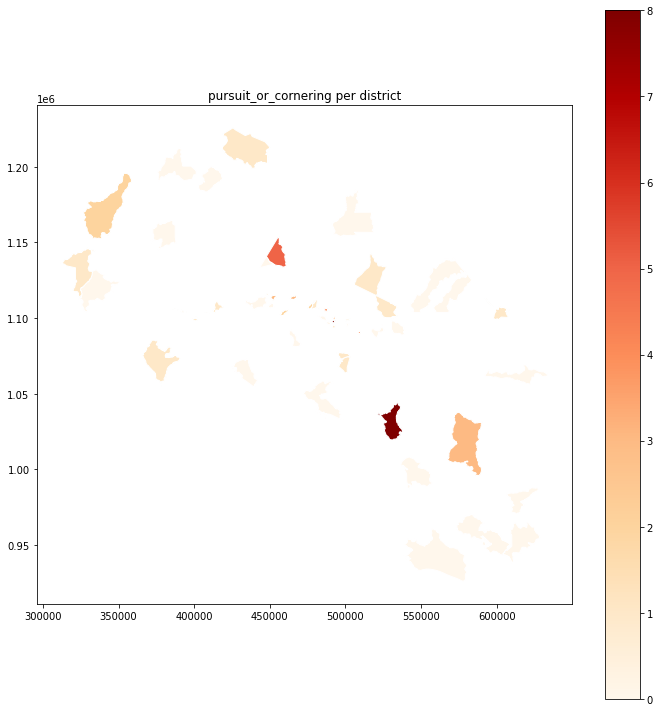

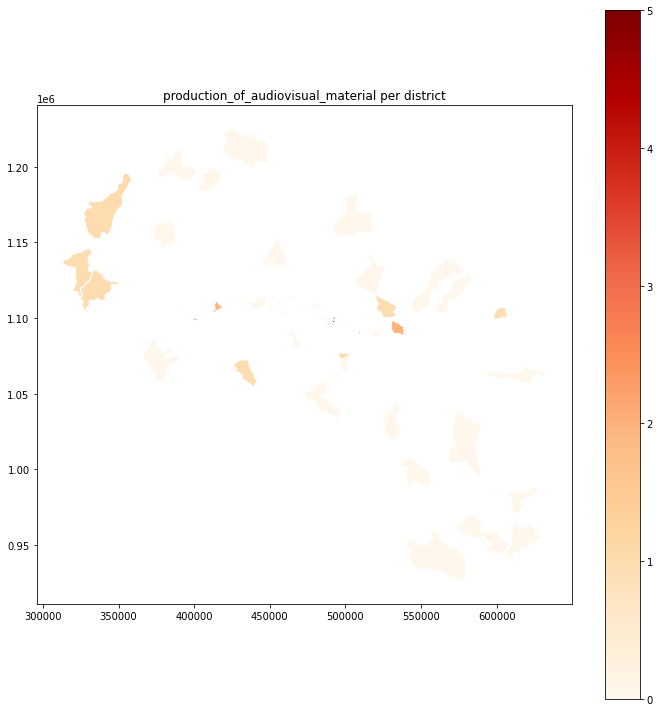

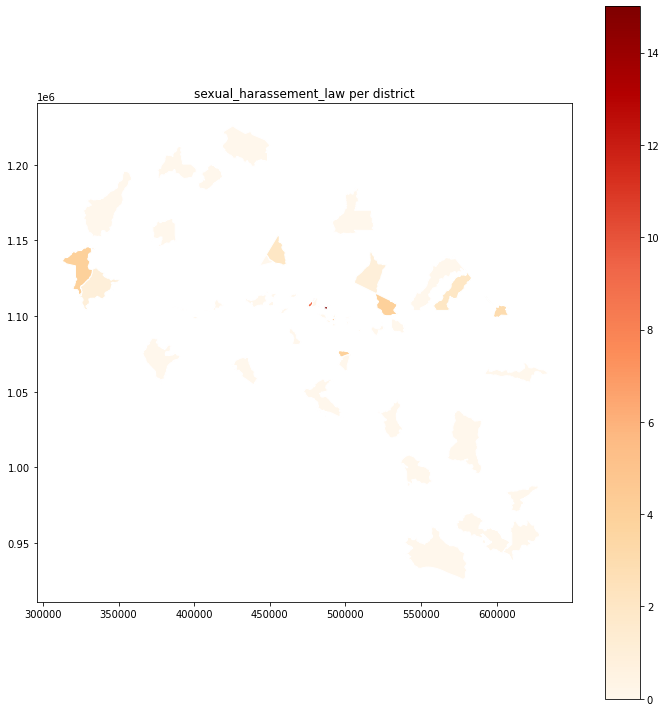

In [ ]:
df_district = sex_har.groupby(["district"])[types_sh].sum().reset_index()

district = pd.merge(district, df_district, how = "left",
                     left_on = "NOM_DIST", right_on = "district")

for i in types_sh:

  fig, ax = plt.subplots(figsize=(10,10))
  
  district.plot(column = i,
                legend = True,
                edgecolor = "white",
                cmap = "OrRd",
                ax = ax)

  #texts =[ax.text(row.coords[0], row.coords[1], s=row["NPROVINCIA"], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}) for idx, row in provinces.iterrows()]

  plt.title("{} per district".format(i))
  plt.tight_layout()

  plt.show()

In the analysis per district and canton we can observe many polygons whitout values. Each type of sexual harassment shows different trends especially when is studied per district, the major resolution in the analysis.

#### 1.3. Conclusions

We identify some trends in the crimes dataset, especially related to hour. On the other hand, we locate the prevalence of some crimes considering districts or canton in Costa Rica. 

Related to sexual harassment data, it is not enough to perform a deeper analysis of their trends especially due to lack of information related to time, day, age, and year. The government must to reinforce the collection of those kind of data if they want to forecast and built index per districts or cantons in Costa Rica.

Finally, we decide to identify subcategories in the crime dataset to work in the forecast. We porform a deeper analysis on those crimes considering their influence by sex (higher rates in women). We identify six categories ['BREAKING WINDOWS', 'VERBAL INTIMIDATION', 'BLINDS REMOVAL', 'ATM WITHDRAWAL', 'DOMESTIC VIOLENCE', 'OUTBURST', 'FEMICIDE'] to work

### 2. Forecast


We create a model for the forecast of number crimes that affect women in each district of San Jose. The work is done in two stages. First, we perform a data analysis process in which the crimes that affect women are determined over the total crimes in San Jose. Second, we use this information to construct time series of crimes for each one of the 11 districts of San Jose. We cross-validate and train a model with this data. This model is then used to create monthly prediciton of the selected crimes over the 11 district of San Jose. The model is able to outperform a naive forecast in the MAE metric. This shows its potential to predict the trend of crime in the districts of San Jose. 

#### 2.1. Data preparation

In the forecast we are going to use a set of crimes that are denominated as crime againts women. Those were filtered and analysed in the section 

In [ ]:
path_crime ='/content/drive/MyDrive/GeoNEAS/gender-s3/data/raw/urbanalytica_datasets/datasets/costa_rica_crime_data_english/costa_rica_crimes_english.csv'
df_crime = pd.read_csv(path_crime)

# Columns that are not useful are deleted
# We restrict the data to the only Canton that is relevant for this work, San Jose. 
df_crime = df_crime.drop(columns=['Unnamed: 0'])
df_crime = df_crime[df_crime.Canton.isin(['SAN JOSE'])]
df_crime = df_crime[~(df_crime.District.isin(['DESCONOCIDO']))]
df_crime.head()


# Some crimes that we consider, due to their nature not gender-based, are deleted from the data. They are minor theft crimes.
df_crime = df_crime[~(df_crime.SubtypeCrime.isin(['DECEIT/DISTRACTION','PICKPOCKETING',
                                                  'WITH A WRENCH','DUE TO TRUST',
                                                  'OTHER OR UNDETERMINED','DUE TO NEGLECT',
                                                  'PROGRESSIVE THEFTS DURING THE DAY',
                                                  'UNKNOWN','PICKLOCK']))]

#We split the data into two parts, casases of crimes committed against men and agains women. 
#The idea here is to find the proportion of crimes that are committed against women in relation to the global amount of crimes. 
#Then, the crimes that disproportionately ocurr against women are selected as the ones we choose for the forecast.

female_crimes = df_crime[df_crime.Gender.isin(['female', 'unknown'])]
male_crimes = df_crime[~(df_crime.Gender.isin(['female', 'unknown']))]
dict_crime_gender = {'subCrime':[],'female_proportion':[]}

SubCrimeList= pd.unique(df_crime.SubtypeCrime[~(df_crime.SubtypeCrime.isna())])
for i in SubCrimeList:
  nFemale = len(female_crimes[female_crimes.SubtypeCrime==i])
  nMale = len(male_crimes[male_crimes.SubtypeCrime==i])
  
  dict_crime_gender['subCrime'].append(i)
  dict_crime_gender['female_proportion'].append(nFemale/(nFemale+nMale))

df_female_crime= pd.DataFrame.from_dict(dict_crime_gender).sort_values(by='female_proportion').reset_index(drop=True) 

# We select the ones that are over the avarage as the set of crimes that mostly affect women

n = df_female_crime.female_proportion.mean()
selected_crimes =(df_female_crime[df_female_crime.female_proportion>n]).subCrime.to_list()

#The dataset of crimes committed against women is restricted to only the selected crimes.

female_crimes['Date'] = pd.to_datetime(female_crimes['Date'].str.replace('.','-'), format='%d-%m-%y')
df_selected_crimes = female_crimes[female_crimes.SubtypeCrime.isin(selected_crimes)].sort_values(by=['Date'])
df_selected_crimes.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Crime SubtypeCrime       Date                 Time  \
612967  ASSAULT     OUTBURST 2010-01-01  18:00:00 - 20:59:59   
612654  ASSAULT     OUTBURST 2010-01-04  12:00:00 - 14:59:59   
610498  ROBBERY   ESCALATION 2010-01-04  00:00:00 - 02:59:59   
645159  ASSAULT      HITTING 2010-01-04  15:00:00 - 17:59:59   
628359  ROBBERY        FORCE 2010-01-04  00:00:00 - 02:59:59   

                    SubtypeVictim       Age  Gender Nationality  Province  \
612967        PEDESTRIAN [PERSON]   >18 y/o  female  COSTA RICA  SAN JOSE   
612654        PEDESTRIAN [PERSON]   >18 y/o  female  COSTA RICA  SAN JOSE   
610498  NOT APPLICEABLE [HOUSING]  > 60 y/o  female  COSTA RICA  SAN JOSE   
645159              CAR [VEHICLE]   >18 y/o  female  COSTA RICA  SAN JOSE   
628359        NOT DEFINED [OTHER]  > 60 y/o  female  COSTA RICA  SAN JOSE   

          Canton      District  
612967  SAN JOSE        ZAPOTE  
612654  SAN JOSE      CATEDRAL  
610498  SAN JOSE  MATA REDONDA  
645159  SAN JOSE  MATA REDONDA  
628359  SAN JOSE      HOSPITAL

#### 2.2. Forecast

This section focuses on the forecast of the crimes againt women by district. Columns that are not useful are deleted, and also we restrict the data to the only canton that is relevant for this work, San Jose. 

The crimes are give by day. We group them by quater so the data is less noisy

In [ ]:
date = df_selected_crimes['Date'].astype('datetime64[M]')
df_selected_crimes['Month']= pd.PeriodIndex(date, freq='M').to_timestamp()

We generate the list of Districts in San Jose

In [ ]:
district_list= (pd.unique(df_selected_crimes.District))
print(district_list)

['ZAPOTE' 'CATEDRAL' 'MATA REDONDA' 'HOSPITAL' 'MERCED' 'HATILLO' 'PAVAS'
 'URUCA' 'SAN FRANCISCO DE DOS RIOS' 'CARMEN' 'SAN SEBASTIAN']


Count of Crime per Quarter and District is generated

In [ ]:
df_selected_crimes['counter'] = 1
df_counts = df_selected_crimes[['Month','counter','District']].groupby(by=['Month','District'] , as_index=False).count()
df_counts.head()

Month      District  counter
0 2010-01-01        CARMEN        3
1 2010-01-01      CATEDRAL        6
2 2010-01-01       HATILLO       15
3 2010-01-01      HOSPITAL        6
4 2010-01-01  MATA REDONDA        5

In [ ]:
df_counts = df_counts.rename(columns={"Month": "ds", "counter": "y"})
df_counts[(df_counts.District=='CARMEN')]
df_counts_save = df_counts.rename(columns={'District':'districts'})
df_counts_save

ds                  districts   y
0    2010-01-01                     CARMEN   3
1    2010-01-01                   CATEDRAL   6
2    2010-01-01                    HATILLO  15
3    2010-01-01                   HOSPITAL   6
4    2010-01-01               MATA REDONDA   5
...         ...                        ...  ..
1574 2022-04-01                     MERCED   7
1575 2022-04-01                      PAVAS   3
1576 2022-04-01  SAN FRANCISCO DE DOS RIOS   1
1577 2022-04-01              SAN SEBASTIAN   1
1578 2022-04-01                     ZAPOTE   2

[1579 rows x 3 columns]

##### 2.2.1. Seasonality

First, we study the times series to see whether they have any seasonality.

##### 2.2.1.1. San Francisco de dos rios


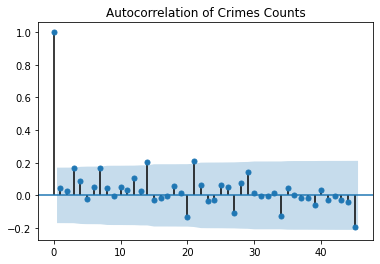

In [ ]:
data =  df_counts[df_counts.District=='SAN FRANCISCO DE DOS RIOS'][['y']]
ax = plot_acf(data, lags=45,title ='Autocorrelation of Crimes Counts')

##### 2.2.1.2. Carmen

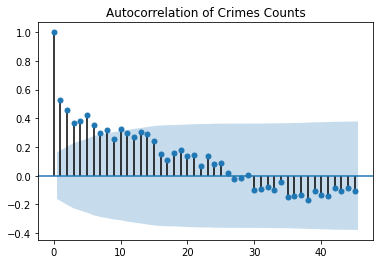

In [ ]:
data =  df_counts[df_counts.District=='CARMEN'][['y']]
ax = plot_acf(data, lags=45,title ='Autocorrelation of Crimes Counts')

##### 2.2.1.3. Merced

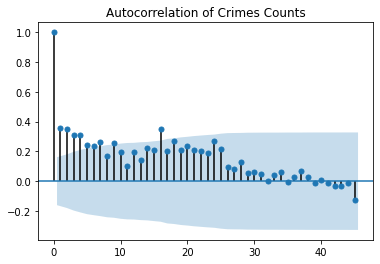

In [ ]:
data =  df_counts[df_counts.District=='MERCED' ][['y']]
ax = plot_acf(data, lags=45,title ='Autocorrelation of Crimes Counts')


In both cases, a similar behavior is observed. The autocorrelation seen for the three times series of is not significant for 45 lapses. This indicates that there is not a significat periodic/seasonal behavior in the time series over time. This conclusion allows for the additional work to pass over the modelling of seasonal behavior.

The observations shown here are representative of the general behavior. During the development of this work about 100% of all time series present in the data were observed and the behavior shown above persisted. This allows for the conclusion done for this thre cases to be extended to all other time series. 

**Note**: for sake of simplicty only were shown here.

#### 2.3. Forecast Model

**Model**

For the model, we choose to use the library prophet since its method has some advantages:

1. Prophet is a modular model and we can choose to model trend alone and add seasonal components. For our data we've seen that we want to model trend alone.
2. The model handles missing data. This aids us to reduce the preprocessing load since imputation on this data is not trivial. We also figured this was the best option with the available data given time constrains
3. This model gives probabilistic bound estimates for prediction
4. Prophet has an integrated cross validation scheme that made simpler the evaluation of performance.

First, we define the cut-offs of the training. Then, the we define the period of prediction after the cutoffs. In this case, the period of prediction is the year after the cutoff.

In [ ]:
CV_CUTOFFS = pd.date_range(start='2019-01-01', end='2020-12-01', freq='3MS')
CV_HORIZON = '366 days'
CV_CUTOFFS

DatetimeIndex(['2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='3MS')

The previous analysis suggested that taking into account the seasonality will not be necesarry. The only parameter we cross-validate is the _changepoint_prior_scale_. The crossvalidation will test in which scale the model performs better.

In [ ]:
base_model_params = dict(
    # no seasonalities
    weekly_seasonality=False, 
    daily_seasonality=False, 
    yearly_seasonality=False,
    changepoint_range=0.9  # since we want to be able to detect recent trend changes
    # mcmc_samples=100  # no mcmc in order to reduce training time. Though this leaves out bound estimates
)

changepoint_scales = np.logspace(start=-2, stop=1, num=4, base=10)
changepoint_scales

array([ 0.01,  0.1 ,  1.  , 10.  ])

The basic function for evaluation is defined. In this case, the metric used is the MAE. Addiotionally, we define the necesarry function to perfom the training. 

In [ ]:
def get_mae(df_cv):
  """
  From a prophet cv dataframe of forecast with predictions for each cutoff, 
  calculate the overall mae (across cutoffs and horizons)
  """
  df_p = performance_metrics(df_cv, rolling_window=1)

  return df_p.mae.iloc[0]

def train_single_model(data, target, prophet_parameters):
  """
  Trains a prophet for a single district, 
  """
  fitted_model = Prophet(**prophet_parameters).fit(data)
  return fitted_model

def score_single_model(m):
  """
  Given a trained model, performs cross validation 
  and then calculate the metric that we defined before
  """
  df_cv = cross_validation(m, cutoffs=CV_CUTOFFS, horizon=CV_HORIZON, parallel='processes')
  tract_mae = get_mae(df_cv)

  return tract_mae

def bulk_train_and_cv(data_districts, target, model_parameters):
  """
  Takes a df with series for multiple fips
  trains a prophet for each and cross validates the scores

  Args:
    data_districts: df with series for multiple fips
    target: name of the target column that represents timeseries
    model_parameters: common parameters to train all models
  """
  models = data_districts.groupby('District').apply(lambda x: train_single_model(x, target, model_parameters))
  cv_scores = models.apply(score_single_model)

  return models, cv_scores

In the following section, the crossvalidation is performed.

In [ ]:
best_params = None
best_score = None

for i, pc in enumerate(tqdm(changepoint_scales)):
  
  variable_params = dict(
      changepoint_prior_scale=pc
  )
  print(f"Running trial {i} with parameters {variable_params}")
  

  model_parameters = {**base_model_params, **variable_params}
  _, cv_scores = bulk_train_and_cv(df_counts, 'y', model_parameters)

  mean_cv_score = cv_scores.mean()

  # update best score and params
  if best_score is None or mean_cv_score < best_score:
    best_score = mean_cv_score
    best_params = model_parameters

  print(f'Score for trial {i}: {mean_cv_score}; current best score: {best_score}')

  0%|          | 0/4 [00:00<?, ?it/s]

Running trial 0 with parameters {'changepoint_prior_scale': 0.01}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50fe4d0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50a7d50>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac502ab90>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50d3a50>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50c2550>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50d1450>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50e4250>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50d29d0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPool

Score for trial 0: 3.29913321463096; current best score: 3.29913321463096
Running trial 1 with parameters {'changepoint_prior_scale': 0.1}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3ed1410>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3eccbd0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3ed7ed0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3ee5ad0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3ed9b90>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3eedc10>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3e7bb90>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3e82bd0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPool

Score for trial 1: 3.6350932063808994; current best score: 3.29913321463096
Running trial 2 with parameters {'changepoint_prior_scale': 1.0}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3e3ff50>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50bd4d0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50d2f10>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50e9a10>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50d10d0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac50d3ad0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac502a6d0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3e9f150>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPool

Score for trial 2: 4.0117098766267185; current best score: 3.29913321463096
Running trial 3 with parameters {'changepoint_prior_scale': 10.0}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3e44690>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3e86590>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3eeded0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3e82b10>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3ed9450>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3ed3b50>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3e7ba90>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ac3e61890>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPool

Score for trial 3: 5.120477643420826; current best score: 3.29913321463096


In [ ]:
print(f"best mean mae: {best_score}")
print(f"best params: {best_params}")

best mean mae: 3.29913321463096
best params: {'weekly_seasonality': False, 'daily_seasonality': False, 'yearly_seasonality': False, 'changepoint_range': 0.9, 'changepoint_prior_scale': 0.01}


We find that the best parameter corresponds to a prior scale of 0.01, which is a model relatively sensible to trend changes.

2.4. Comparison against the baseline

After defining the optimal parameter, the next stage is to compare the prediction done by our model against a naive baseline. The idea is to train the model with a dataset in the interval between 2021-01-01' and '2022-01-01. Then, we use the trained model to predict the period between '2022-01-01' and'2023-03-01'. At the same time, we create a naive prediction, which are the same values seen in the series the previous year: 2021-01-01' and'2022-03-01'. 

For each prediciton set, the MAE is obtained and the values are compared to asses which prediction is *better*.

In [ ]:
model_parameters = dict(
    changepoint_prior_scale=0.01,
    # no seasonalities
    weekly_seasonality=False, 
    daily_seasonality=False, 
    yearly_seasonality=False,
    changepoint_range=0.9,  # since we want to be able to detect recent trend changes
    # mcmc_samples=100  # no mcmc in order to reduce training time. Though this leaves out bound estimates
)

The forecast is created using the following functions.

In [ ]:
def generate_forecast(model, future):
  """
  Model predictions for the given future df
  """
  return model.predict(future)

def bulk_train_and_forecast(data_districts, target, model_parameters, future):
  """
  Takes a df with series for multiple fips and calculates the forecast for each

  Args:
    tdata_districtsract_loads: df with series for multiple districts
    target: name of the target column that represents timeseries
    model_parameters: parameters to train all models
    future: common horizon to generate predictions for all tracts
  """
  forecasts_list = []

  for districts, tract_data in tqdm(data_districts.groupby('District')):
    # iterate over the single fips series
    try:
      # train model
      model  = train_single_model(tract_data, target, model_parameters)
      # generate forecast
      forecast = generate_forecast(model, future)
      forecast = forecast[['ds', 'yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]
      # this adds the fips (series index) as  column to each forecast
      forecast = forecast.assign(districts=districts, target=target)

      forecasts_list.append(forecast)
    except ValueError as e:
      # some series fail since all the observations are na (eg a tract wih no recycling records)
      print(e)

  return pd.concat(forecasts_list)

We generate the prediciton with the model and evaluate its result using the mae against the values seen in reality

In [ ]:
#Test set is generated
filtered_district_train = df_counts.query("ds>='2021-01-01' and ds<'2022-01-01'")
#Dates for prediction are defined
future = pd.DataFrame({'ds': pd.date_range(start='2022-01-01', end='2023-03-01', freq='MS')})
#Model is trained and predictions are generated
filtered_district_test_predict = bulk_train_and_forecast(filtered_district_train,'y', model_parameters,future)
#Actual values seen in reality are retrived
filtered_district_test = df_counts.query("ds>'2022-01-01' and ds<'2022-04-01'") 
filtered_district_test =filtered_district_test.rename(columns={'District':'districts'})

#Mae is generated
merged_set= pd.merge(filtered_district_test_predict,filtered_district_test, on = ['ds','districts'],how='inner')

100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


Prediction's MAE

In [ ]:
print(np.mean(abs(merged_set.yhat-merged_set.y)))

3.1651400621395447


MAE of naive prediction is obtained

In [ ]:
#Test set is generated
filtered_district_test = df_counts.query("ds>'2022-01-01' and ds<'2022-04-01'") 
#Naive prediciton is generated
filtered_district_predict_naive = df_counts.query("ds>'2021-01-01' and ds<'2021-04-01'") 
filtered_district_predict_naive.ds = filtered_district_predict_naive.ds + pd.offsets.DateOffset(years=1)
filtered_district_predict_naive = filtered_district_predict_naive.rename(columns={'y':'y_naive'})
#Mae is obtained
merged_set= pd.merge(filtered_district_predict_naive,filtered_district_test, on = ['ds','District'],how='inner')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Naive prediction MAE

In [ ]:
mean(abs(merged_set.y_naive-merged_set.y))

3.8421052631578947

The conclusion of this section is that the model generated is better than the naive prediction. The model obtained a MAE 3.16 whike the naive preiction was 3.8. It was around 10% better

#### 2.4. Predictions

The prediction are generated.

We first define the forecast period

In [ ]:
#the forecast period is from 2022-04-01 to 2023-10-01.
future = pd.DataFrame({'ds': pd.date_range(start='2022-04-01', end='2023-12-01', freq='MS')})
future

ds
0  2022-04-01
1  2022-05-01
2  2022-06-01
3  2022-07-01
4  2022-08-01
5  2022-09-01
6  2022-10-01
7  2022-11-01
8  2022-12-01
9  2023-01-01
10 2023-02-01
11 2023-03-01
12 2023-04-01
13 2023-05-01
14 2023-06-01
15 2023-07-01
16 2023-08-01
17 2023-09-01
18 2023-10-01
19 2023-11-01
20 2023-12-01

The training data is retrieved

In [ ]:
filtered_district = df_counts.query("ds>='2021-01-01' and ds<'2022-04-01'")
district_forecasts = bulk_train_and_forecast(filtered_district,'y', model_parameters,future)

100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


In [ ]:
district_forecasts[(district_forecasts.districts=='CARMEN')]

ds      yhat  yhat_lower  yhat_upper     trend  trend_lower  \
0  2022-04-01  3.947058    1.376445    6.617503  3.947058     3.947058   
1  2022-05-01  3.903848    1.389341    6.402055  3.903848     3.903848   
2  2022-06-01  3.859197    1.167230    6.318203  3.859197     3.859197   
3  2022-07-01  3.815987    1.304209    6.364094  3.815987     3.815987   
4  2022-08-01  3.771337    1.335367    6.096949  3.771337     3.771337   
5  2022-09-01  3.726686    1.271509    6.282601  3.726686     3.726686   
6  2022-10-01  3.683476    1.016011    6.231649  3.683476     3.683476   
7  2022-11-01  3.638826    1.138365    6.233760  3.638826     3.638826   
8  2022-12-01  3.595616    1.025128    6.175414  3.595616     3.595616   
9  2023-01-01  3.550966    1.010160    6.225646  3.550966     3.550965   
10 2023-02-01  3.506315    0.863377    6.076656  3.506315     3.506315   
11 2023-03-01  3.465986    0.772676    5.913455  3.465986     3.465986   
12 2023-04-01  3.421335    0.916412    6.057816  3.421335     3.421335   
13 2023-05-01  3.378125    0.700901    5.895061  3.378125     3.378125   
14 2023-06-01  3.333475    0.784918    5.649476  3.333475     3.333475   
15 2023-07-01  3.290265    0.801050    5.957342  3.290265     3.290265   
16 2023-08-01  3.245615    0.756568    5.802745  3.245615     3.245614   
17 2023-09-01  3.200964    0.640764    5.747948  3.200964     3.200964   
18 2023-10-01  3.157754    0.699536    5.802327  3.157754     3.157754   
19 2023-11-01  3.113104    0.573154    5.605366  3.113104     3.113103   
20 2023-12-01  3.069894    0.585033    5.597360  3.069894     3.069893   

    trend_upper districts target  
0      3.947058    CARMEN      y  
1      3.903848    CARMEN      y  
2      3.859197    CARMEN      y  
3      3.815987    CARMEN      y  
4      3.771337    CARMEN      y  
5      3.726686    CARMEN      y  
6      3.683476    CARMEN      y  
7      3.638826    CARMEN      y  
8      3.595616    CARMEN      y  
9      3.550966    CARMEN      y  
10     3.506315    CARMEN      y  
11     3.465986    CARMEN      y  
12     3.421336    CARMEN      y  
13     3.378126    CARMEN      y  
14     3.333475    CARMEN      y  
15     3.290265    CARMEN      y  
16     3.245615    CARMEN      y  
17     3.200965    CARMEN      y  
18     3.157755    CARMEN      y  
19     3.113104    CARMEN      y  
20     3.069894    CARMEN      y

#### 2 5. Conclusions

A forecast was implemented over the data of the districs of San Jose. The model is able to outperform a naive forecast in the MAE metric. This shows its potential to predict the trend of crime in the districts of San Jose. Currently, the main drawback of the work in this section is the lack of records of crimes in the city. This lack of data give for quite noisy time series which affects the forecast. This will be fixed with the inclusion of further data. The use of community reporting in other sections of this proyect will in the long run alleviate this problem.

### 3. Cases simulation and spatial model

We built an explicative spatial model with simulated crimes points in San José as dependent variable and built environment variables (as [2]) constructed with geographical data share by Urban Analityca and retrieved from Open Street Map. We consider spatial autocorrrelation in the model consequently we train an spatial error model finding some variables that have more influence in the increase of crimes. Road infrastructure and number of buildings icnrease the number of crimes meanwhile the land use features, population and recreational areas have the potential to improve the safe in the zones.


**Features**

We have previously created hexagons areas covering San Jose [6]. We choose this city because we had access to several geographical datasets to feed the spatial model. The spatial feature engineering process can be checked in the **data and pre processing** (attached as appendix). The features we include can be grouped in the following:

* 'count_pois' = Count of Points of interests (POIs) in the polygon extracted from Open Street Map.

* 'pois_ha' = Count of POIs per hectarea.

* 'count_heritage' = Count of heritage buildings in the hexagon

* 'water_ha' = Area of water bodies in the hexagon in hectarea

* 'ped_ha' = Area of bulevards in the hexagon in hectareas

* 'parks_ha' = Area of parks in the hexagon in hectareas

* 'recre_ha' = Area of recreational facilities in the hexagon in hectareas

* 'condos_ha' = Area of condos in the hexagon in hectareas

* 'num_prop' = Number of properties in the hexagon

* 'num_churches' = Number of churches in the hexagon

* 'num_malls' = Number of shopping malls in the hexagon

* 'communal_ha' = Area of comunal zones in the hexagon in hectareas

* 'basic_ha' = Area of basic educational facilities in the hexagon in hectareas

* 'higher_ha' = Area of higher educational facilities in the hexagon in hectareas

* 'basic_count' = Count of basic educational facilities in the hexagon

* 'higher_count' = Count of higher educational facilities in the hexagon

* 'culture_ha' = Area of cultural facilities in the hexagon in hectareas

* 'admin_ha' = Area of administrative and institutional facilities in the hexagon in hectareas

* 'green_ha' = Area of green and public spaces in the hexagon in hectareas

* 'health_count' = Count of health facilities in the hexagon

* 'sec_count' = Count of security facilities in the hexagon

* 'assist_count' = Count of assistional facilities in the hexagon

* 'risky_f_ha' = Area of risky zones related to floods in the hexagon in hectareas

* 'Other_use', 'commercial', 'institutional', 'mixed', 'recreational',
'residential' = Area of land use per category in hectareas

* 'boulevards', 'local', 'main', 'other_roads', 'pedestrian' = length per road category in meters in the study area

* 'Pop_hex' = Population in the hexagon extracted from National Census by district and distributed using area.


We will go through the process of crimes simulation, train the model and analysis.


#### 3.1. Cases simulation

We note that this model assumes that the population density of possible cases is constant across the map. This is in general not the case but we are using it as a simplification for the calculation, we hope that collected data through the form reflects better affluential zones.

The generative process:

1. Create risk probability based on qualitative model (on h3 grid)
2. Sample a point within the big geometry and find the polygon in which it fell
3. Accept point with probability given by risk probability in the containing hexagon
4.  Repeat until population is exhausted

In [ ]:
BASE_PATH = '/content/drive/MyDrive/GeoNEAS/gender-s3/data'
basemap = gpd.read_file(f'{BASE_PATH}/model_input/hex_predict_whitout_crimes_HEX_10.geojson')
basemap.columns

Index(['h3_polyfill', 'index', 'OBJECTID', 'Id_Distrito', 'Nombre',
       'Shape.STArea()', 'Shape.STLength()', 'Area_calc', 'Area_hex',
       'POB2016', 'POB2017', 'POB2018', 'Pop_hex', 'count_pois', 'pois_ha',
       'count_heritage', 'water_ha', 'ped_ha', 'parks_ha', 'recre_ha',
       'condos_ha', 'num_prop', 'num_churches', 'num_malls', 'communal_ha',
       'basic_ha', 'basic_count', 'higher_ha', 'higher_count', 'culture_ha',
       'admin_ha', 'green_ha', 'health_count', 'sec_count', 'assist_count',
       'risky_f_ha', 'Other_use', 'commercial', 'institutional', 'mixed',
       'recreational', 'residential', 'boulevards', 'local', 'main',
       'other_roads', 'pedestrian', 'geometry'],
      dtype='object')

##### 3.1.1. Qualitative risk score

Lets generate a risk score based on the following:


1. Lighning
2. openness 
3. visibility
4. density of people
5. security
6. pathway
7. public transportation
8. diversity of people

- (- risk) 'count_pois' = Count of POI in the polygon
- (- risk) 'num_prop' = Number of properties in the hexagon
- (- risk) 'condos_ha' = Area of condos in the hexagon in hectareas
- (- risk) 'admin_ha'
- (- risk)'sec_count' = Count of security facilities in the hexagon
- (- risk)'assist_count' = Count of assistional facilities in the hexagon
- 'Other_use', 'commercial', 'institutional', 'mixed', 'recreational', (-risk)'residential' = Area of land use per category in hectareas

- 'boulevards', 'local', 'main', 'other_roads', 'pedestrian' = length per road category in meters in the study area


In order to combine these into a risk factor, we should probably standarize them in some sort. We will performa a simple minmax

Note that the effect of all these is to reduce risk, so we need to do inverse tranformations in order to generate a risk score, that is, if the variable is high, its contribution to the risk score should be small. Since we performed a minmax on the features, we could just do $1 - feature$

In [ ]:
qualitative_risk_factors = [
  'num_prop', 'condos_ha',  'admin_ha', 'sec_count', 'assist_count', 'assist_count', 'residential', 'local']

risk_factor_values = basemap[qualitative_risk_factors]

risk_factor_values.describe()

num_prop    condos_ha     admin_ha    sec_count  assist_count  \
count  2941.000000  2941.000000  2941.000000  2941.000000   2941.000000   
mean     32.053383     0.035416     0.013095     0.016661      0.004760   
std      28.700237     0.128460     0.064698     0.147754      0.082341   
min       1.000000     0.000000     0.000000     0.000000      0.000000   
25%       7.000000     0.000000     0.000000     0.000000      0.000000   
50%      27.000000     0.000000     0.000000     0.000000      0.000000   
75%      48.000000     0.000000     0.000000     0.000000      0.000000   
max     201.000000     1.503502     0.935437     4.000000      2.000000   

       assist_count  residential        local  
count   2941.000000  2941.000000  2941.000000  
mean       0.004760     0.356415  1674.941132  
std        0.082341     0.413431  1565.055389  
min        0.000000     0.000000     0.000000  
25%        0.000000     0.000000   456.943496  
50%        0.000000     0.156086  1371.072762  
75%        0.000000     0.696539  2741.904477  
max        2.000000     1.498426  9138.305922

In [ ]:
scaler = MinMaxScaler()
risk_factor_values = scaler.fit_transform(risk_factor_values)

# inverse transformation since all of the factors are correlated with reduced risk
risk_factor_values = 1 - risk_factor_values

np.mean(risk_factor_values, axis=1)

array([0.93760914, 0.93742234, 0.97627051, ..., 0.89726201, 0.98125   ,
       0.90534484])

Score is calculated by taking the average of all factors. We assume that all factors have the same weight.

In [ ]:
risk_factor_map = basemap[['h3_polyfill', 'geometry']].copy().set_index('h3_polyfill')
risk_factor_map['risk_score'] = np.mean(risk_factor_values, axis=1)

risk_factor_map.sample(3)

geometry  risk_score
h3_polyfill                                                                   
8a6d6936141ffff  POLYGON ((-84.06701 9.90904, -84.06760 9.90867...    0.852041
8a6d693298b7fff  POLYGON ((-84.15278 9.96005, -84.15338 9.95967...    0.975657
8a6d69360aa7fff  POLYGON ((-84.07007 9.92384, -84.07066 9.92347...    0.901961

Smmothing to simulate spatial dependency

In [ ]:
min_current_factor = risk_factor_map.risk_score.min()
min_current_factor

0.6329732239321415

Lets visualize the map

In [ ]:
fig = px.choropleth_mapbox(
    risk_factor_map,
    geojson=risk_factor_map.geometry,
    locations=risk_factor_map.index,
    color="risk_score",
    opacity=0.6,
    center={"lat": risk_factor_map.unary_union.centroid.y, "lon": risk_factor_map.unary_union.centroid.x},
    zoom=12,
    color_continuous_scale='YlOrRd',
    mapbox_style="open-street-map",)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

##### 3.1.2. Simulating points

Now lets generate points within the map that could be possible cases, to genereate the points, we will use the road insfrastructure of the city, since these represent the places that could be understood as public places.

In [ ]:
def sample_points_in_gdf(gdf, max_points, rng):
  # Use GeoSeries.total_bounds if you would like the limits of the entire series
  x_min, y_min, x_max, y_max = gdf.total_bounds

  x = rng.uniform(x_min, x_max, max_points)
  y = rng.uniform(y_min, y_max, max_points)

  gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x, y), crs=gdf.crs)

  gdf_points = gdf_points.sjoin(gdf[['geometry']], how='inner')

  return gdf_points[['geometry']]

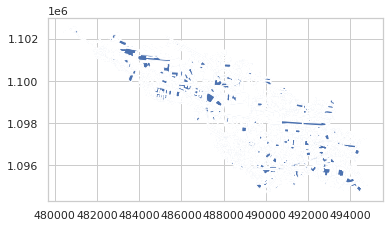

In [ ]:
# load roads
roads = gpd.read_file(f'{BASE_PATH}/raw/urbanalytica_datasets/datasets/Geodataframes/arcGIS_vialidad.geojson')
# turn lines into wide 10m geometries
roads['geometry'] = roads.geometry.buffer(10)
roads.plot()

CPU times: user 16.5 s, sys: 198 ms, total: 16.7 s
Wall time: 16.5 s


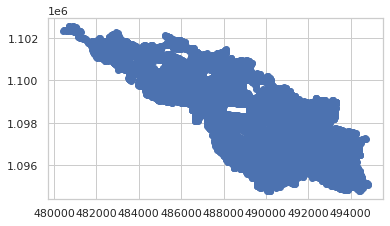

In [ ]:
%%time

rng = np.random.default_rng(52)
MAX_CASES = 100000

cases = sample_points_in_gdf(roads, MAX_CASES, rng)
cases.plot()

In [ ]:
cases = cases.to_crs(risk_factor_map.crs)

def run_trials(p, rng):
  return rng.binomial(n=1, p=p)

Each one of this could be a potential case. And each falls in a risk area. Now we join with the gdf and only accept points if the pass a trial. It could be interpreted as throwing a coin and it ends up in a violence case with probability given by the risk factor

In [ ]:
cases = cases.sjoin(risk_factor_map.reset_index())
cases['trial_result'] = run_trials(cases.risk_score, rng)

cases.trial_result.value_counts()

1    17565
0     1949
Name: trial_result, dtype: int64

Keep only cases that endep up with a value of 1 for the trial(coin toss)

In [ ]:
cases = cases.query('trial_result==True').copy()

Now we add other information such as time of day and weekday. Note that according to the form the cases will likely have more fields but we keep this one simple as a sample. Next iterations of the models could include more variables.

- Morning 5 am to 12 pm (noon)
- Afternoon 12 pm to 5 pm.
- Evening 5 pm to 9 pm.
- Night 9 pm to 4 am.

In [ ]:
cases['time_of_day'] = rng.choice(
    ['1_morning', '2_afternoon', '3_evening', '4_night'],
    size=cases.shape[0],
    p=[0.2, 0.1, 0.3, 0.4]
)

list(range(0,7))

[0, 1, 2, 3, 4, 5, 6]

Now we sample weekdays (sunday is 0)

In [ ]:
cases['weekday'] = rng.choice(
    range(0,7),
    size=cases.shape[0],
    p=[0.1, 0.1, 0.1, 0.2, 0.1, 0.2, 0.2]
)

Lets save the cases

In [ ]:
cases.head()

geometry  index_right      h3_polyfill  risk_score  \
16     POINT (-84.11432 9.94385)         1465  8a6d69adb0dffff    0.973748   
10981  POINT (-84.11419 9.94356)         1465  8a6d69adb0dffff    0.973748   
13394  POINT (-84.11413 9.94364)         1465  8a6d69adb0dffff    0.973748   
36753  POINT (-84.11439 9.94391)         1465  8a6d69adb0dffff    0.973748   
68674  POINT (-84.11437 9.94447)         1465  8a6d69adb0dffff    0.973748   

       trial_result  time_of_day  weekday  
16                1  2_afternoon        1  
10981             1      4_night        3  
13394             1      4_night        0  
36753             1      4_night        5  
68674             1      4_night        2

how many hexagons ended up with data

In [ ]:
cases.h3_polyfill.nunique()

2560

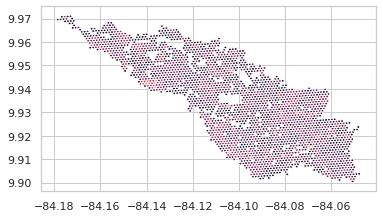

In [ ]:
cases = cases[['geometry', 'time_of_day', 'weekday']]
cases.to_file(f'{BASE_PATH}/model_input/simulated_cases.geojson', driver='GeoJSON')
cases.assign(count=1).h3.geo_to_h3_aggregate(10).plot(column='count')

#### 3.2. Spatial model

We use pandas profiler to quickly get an overview of the features

In [ ]:
BASE_PATH = "/content/drive/MyDrive/GeoNEAS/gender-s3/data/model_input/"

#Reading the hexagons in San Jose with built environment and demographic variables

gdf = gpd.read_file(BASE_PATH + "hex_predict_whitout_crimes_HEX_10.geojson")
gdf.to_crs("EPSG:5367", inplace = True)

# Reading simulated crimes cases

sim_cases = gpd.read_file(BASE_PATH + "simulated_cases.geojson")
sim_cases.to_crs("EPSG:5367", inplace = True)

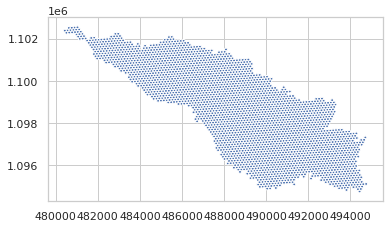

In [ ]:
gdf.plot()

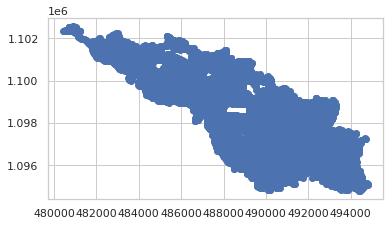

In [ ]:
sim_cases.plot()

We will join spatially the crimes cases with the hexagons. At first we will analyse the total number of crimes

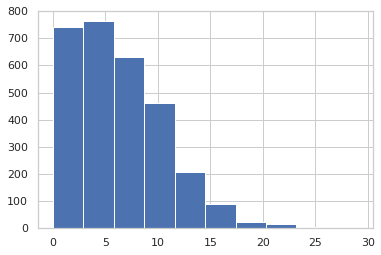

In [ ]:
hex_crimes = gpd.sjoin(gdf[['h3_polyfill', "geometry"]], sim_cases, predicate = "intersects", how = "left")

gdf = pd.merge(gdf, hex_crimes.groupby(['h3_polyfill'])["index_right"].count().reset_index().rename(columns = {"index_right" : "Num_crimes"}),
               on = 'h3_polyfill', how = "left")

gdf["Num_crimes"].hist()

We need to choose the independent variables to verify their nature and to simplify the number of features. Some of them are rebundant and it could have multicolinearity. We keep variables that contains explainability for decision-makers

##### 3.2.1. Checking the independent variables


In [ ]:
ind_variables = ['Pop_hex', 'count_pois' , 'pois_ha', 'count_heritage', 
                'water_ha', 'ped_ha', 'parks_ha', 'recre_ha', 'condos_ha', 'num_prop',
                'num_churches', 'num_malls', 'communal_ha', 'basic_ha', 'basic_count',
                'higher_ha', 'higher_count', 'culture_ha', 'admin_ha', 'green_ha',
                'health_count', 'sec_count', 'assist_count', 'risky_f_ha', 'Other_use',
                'commercial', 'institutional', 'mixed', 'recreational', 'residential',
                'boulevards', 'local', 'main', 'other_roads', 'pedestrian']

corr_pearson = gdf[ind_variables].corr(method='pearson')
round(corr_pearson, 3)                

Pop_hex  count_pois  pois_ha  count_heritage  water_ha  \
Pop_hex           1.000      -0.157   -0.157          -0.127    -0.029   
count_pois       -0.157       1.000    1.000           0.189    -0.082   
pois_ha          -0.157       1.000    1.000           0.189    -0.082   
count_heritage   -0.127       0.189    0.189           1.000    -0.032   
water_ha         -0.029      -0.082   -0.082          -0.032     1.000   
ped_ha           -0.017       0.001    0.001           0.069    -0.017   
parks_ha          0.085      -0.061   -0.061           0.074     0.071   
recre_ha         -0.099      -0.040   -0.040          -0.020     0.175   
condos_ha        -0.021       0.002    0.002          -0.026    -0.023   
num_prop          0.396       0.039    0.039          -0.050    -0.190   
num_churches      0.125       0.039    0.039           0.025    -0.065   
num_malls         0.042       0.180    0.180           0.024    -0.062   
communal_ha       0.004      -0.019   -0.019           0.018    -0.033   
basic_ha          0.020      -0.010   -0.010           0.044    -0.058   
basic_count       0.026      -0.007   -0.007           0.036    -0.067   
higher_ha        -0.099       0.019    0.019           0.069    -0.031   
higher_count     -0.098       0.010    0.010           0.080    -0.029   
culture_ha       -0.077       0.170    0.170           0.339    -0.026   
admin_ha         -0.070       0.047    0.047           0.085    -0.049   
green_ha         -0.070       0.047    0.047           0.085    -0.049   
health_count     -0.020      -0.013   -0.013           0.086    -0.010   
sec_count         0.022       0.096    0.096          -0.015    -0.005   
assist_count     -0.007       0.006    0.006          -0.008    -0.017   
risky_f_ha       -0.070       0.047    0.047           0.085    -0.049   
Other_use         0.060      -0.116   -0.116          -0.050     0.336   
commercial       -0.039       0.314    0.314           0.080    -0.115   
institutional    -0.086      -0.040   -0.040           0.104    -0.090   
mixed            -0.284       0.002    0.002          -0.039    -0.043   
recreational      0.022      -0.064   -0.064           0.001     0.190   
residential       0.307      -0.177   -0.177          -0.109    -0.118   
boulevards       -0.045       0.125    0.125           0.421    -0.029   
local             0.320      -0.017   -0.017          -0.069    -0.205   
main              0.014       0.060    0.060          -0.008    -0.045   
other_roads      -0.145       0.063    0.063           0.056    -0.084   
pedestrian        0.315      -0.056   -0.056          -0.027    -0.045   

                ped_ha  parks_ha  recre_ha  condos_ha  num_prop  ...  \
Pop_hex         -0.017     0.085    -0.099     -0.021     0.396  ...   
count_pois       0.001    -0.061    -0.040      0.002     0.039  ...   
pois_ha          0.001    -0.061    -0.040      0.002     0.039  ...   
count_heritage   0.069     0.074    -0.020     -0.026    -0.050  ...   
water_ha        -0.017     0.071     0.175     -0.023    -0.190  ...   
ped_ha           1.000    -0.015    -0.015     -0.016    -0.072  ...   
parks_ha        -0.015     1.000    -0.060     -0.029    -0.006  ...   
recre_ha        -0.015    -0.060     1.000     -0.055    -0.178  ...   
condos_ha       -0.016    -0.029    -0.055      1.000    -0.101  ...   
num_prop        -0.072    -0.006    -0.178     -0.101     1.000  ...   
num_churches    -0.008    -0.029    -0.047     -0.045     0.133  ...   
num_malls        0.018    -0.049    -0.026      0.096     0.006  ...   
communal_ha     -0.022    -0.028    -0.028     -0.018    -0.082  ...   
basic_ha        -0.036    -0.025    -0.014     -0.040    -0.035  ...   
basic_count     -0.045    -0.029    -0.024     -0.038     0.005  ...   
higher_ha       -0.015    -0.033    -0.014     -0.021    -0.073  ...   
higher_count    -0.013    -0.028    -0.007     -0.025    -0.079  ...   
culture_ha       0.022     0.129    -0.014     -0.014  

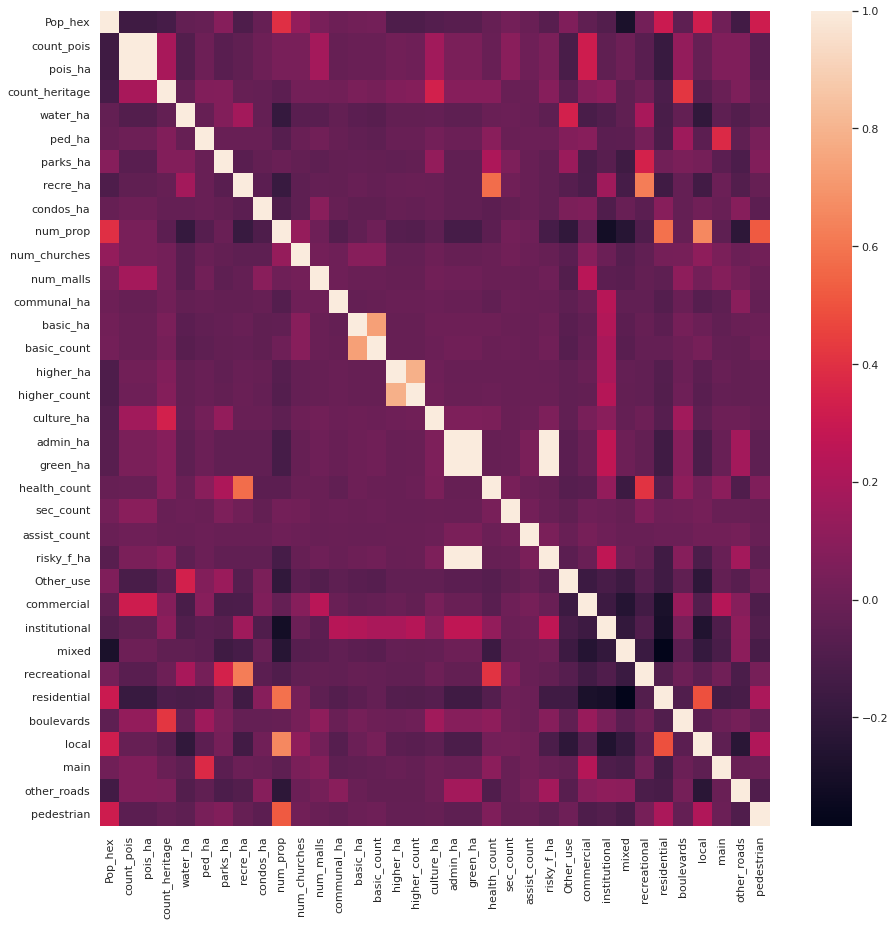

In [ ]:
fig = plt.figure(figsize = (15, 15))
sns.heatmap(corr_pearson)
fig.savefig("Correlation_independent_variables", dpi = 300)

Correlation plot allows to identify that count pois and pois per hectarea has similar behaviour, consequently we are going to keep count pois because the area is not relevant due to haxagons has equal area. Besides, higher and basic education counts will keep in the model, their normalization per area will be delete it. Finally, risky_f_areas, administrative areas and green areas has strong relations. We are going to delete green and administrative areas because they are represented in other features such as parks or institutional land use.
On the other hand, recreational land use will be delete to keep recreation area from their buildings. Furthermore, water bodies features were transformed as dummy variable

In [ ]:
gdf['water_ha'][gdf['water_ha'] > 0] = 1

We want to normalize the variables to give explainability for decission makers

In [ ]:
gdf_norm = gdf.copy()

x = ['Pop_hex', 'count_pois', 'pois_ha', 'count_heritage', 'water_ha',
       'ped_ha', 'parks_ha', 'recre_ha', 'condos_ha', 'num_prop',
       'num_churches', 'num_malls', 'communal_ha', 'basic_ha', 'basic_count',
       'higher_ha', 'higher_count', 'culture_ha', 'admin_ha', 'green_ha',
       'health_count', 'sec_count', 'assist_count', 'risky_f_ha', 'Other_use',
       'commercial', 'institutional', 'mixed', 'recreational', 'residential',
       'boulevards', 'local', 'main', 'other_roads', 'pedestrian']
       
gdf_norm[x] = (gdf_norm[x]-gdf_norm[x].min())/ (gdf_norm[x].max() - gdf_norm[x].min())

##### 3.2.2. OLS model


First we are going to built an OLS model to identify variables that have low influence to explain the number of crimes. Some variables will be delete considering their statistical representativeness and the importance for decission makers

In [ ]:
first_variables = ['count_pois' , 'count_heritage', 'water_ha', 'ped_ha', 'parks_ha', 
                 'recre_ha', 'condos_ha', 'num_prop', 'num_churches', 'num_malls', 
                 'communal_ha', 'basic_count', 'higher_count', 'culture_ha', 'commercial', 
                 'institutional', 'mixed', 'residential', 'boulevards', 'local', 'main', 
                 'other_roads', 'pedestrian', "Pop_hex"]

In [ ]:
#Fits OLS model

m1 = spreg.OLS(
    #Dependent variable
    gdf_norm[["Num_crimes"]].values,
    # Independent variables
    gdf_norm[first_variables].values,
    # Dependent variable name
    name_y = "Num_crimes",
    # Independent variable name
    name_x = first_variables)

print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  Num_crimes                Number of Observations:        2941
Mean dependent var  :      5.9725                Number of Variables   :          25
S.D. dependent var  :      4.5750                Degrees of Freedom    :        2916
R-squared           :      0.3523
Adjusted R-squared  :      0.3469
Sum squared residual:   39859.765                F-statistic           :     66.0756
Sigma-square        :      13.669                Prob(F-statistic)     :  1.831e-253
S.E. of regression  :       3.697                Log likelihood        :   -8006.130
Sigma-square ML     :      13.553                Akaike info criterion :   16062.259
S.E of regression ML:      3.6815                Schwarz criterion     :   16211.922

-----------------------------------------------------------------------------

Most of the features has statistical significance in the model; however, parks_ha, number_churches, num_malls, communal_ha, basic and higher educational counts, culture_ha, commercial and residential land use does not have statistical influence to explain the number of crimes. To simplify the model we will delete culture_ha, communal_ha, number of churches and num_malls. We keep area of parks, land use features and combine higher and basic education because we consider important features following the literature (Sánchez 2021; Gargiulo et al. 2020). On the other hand pedestrian roads was delete it considering that we ha pedestrian areas of public spaces (ped_ha). 

In [ ]:
gdf_norm["Count_edu"] = gdf_norm['basic_count'] + gdf_norm['higher_count']

second_variables = ['count_pois' , 'count_heritage', 'ped_ha', 'parks_ha', "water_ha", 
                    'recre_ha', 'condos_ha', 'num_prop', 'Count_edu',  'commercial', 
                    'institutional', 'mixed', 'residential', 'boulevards', 'local', 'main', 
                    'other_roads', "Pop_hex"]

In [ ]:
#Fits the second OLS model

m2 = spreg.OLS(
    #Dependent variable
    gdf_norm[["Num_crimes"]].values,
    # Independent variables
    gdf_norm[second_variables].values,
    # Dependent variable name
    name_y = "Num_crimes",
    # Independent variable name
    name_x = second_variables)

print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  Num_crimes                Number of Observations:        2941
Mean dependent var  :      5.9725                Number of Variables   :          19
S.D. dependent var  :      4.5750                Degrees of Freedom    :        2922
R-squared           :      0.3499
Adjusted R-squared  :      0.3459
Sum squared residual:   40003.646                F-statistic           :     87.3806
Sigma-square        :      13.691                Prob(F-statistic)     :  6.611e-257
S.E. of regression  :       3.700                Log likelihood        :   -8011.428
Sigma-square ML     :      13.602                Akaike info criterion :   16060.856
S.E of regression ML:      3.6881                Schwarz criterion     :   16174.600

-----------------------------------------------------------------------------

#### 3.3. Checking Spatial Autocorrelation

We need to check spatial autocorrelation in the dependent variable through the weighted matrix. We choose queen contiguity because hexagons could have up to six neighbours each.

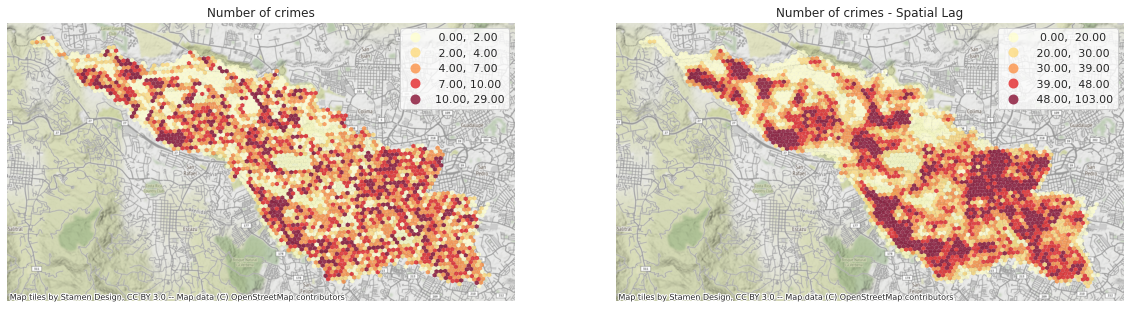

In [ ]:
# Building a weighted matrix considering queen contiguity

wr = weights.contiguity.Queen.from_dataframe(gdf)

gdf_norm["Num_crimes_lag"] = weights.spatial_lag.lag_spatial(wr, gdf_norm["Num_crimes"])


f, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1, ax2 = axs

gdf_norm.plot(
    column="Num_crimes",
    cmap='YlOrRd',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=True,
    ax=ax1
)

ax1.set_axis_off()
ax1.set_title("Number of crimes")

contextily.add_basemap(
    ax1, 
    crs=gdf.crs
)

gdf_norm.plot(
    column='Num_crimes_lag',
    cmap='YlOrRd',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=True,
    ax=ax2
)
ax2.set_axis_off()
ax2.set_title("Number of crimes - Spatial Lag")
contextily.add_basemap(
    ax2, 
    crs=gdf.crs)

plt.show()

f.savefig("Number_crimes_Lag_variables", dpi = 300)

The maps show us the distribution of the Number of Crimes (left) and the Spatial Lag of the variable (right). Spatial Lag explain the influence of the neighbours in the data. We could observe some patterns in the data, clustering the crimes in certains zones of San Jose.

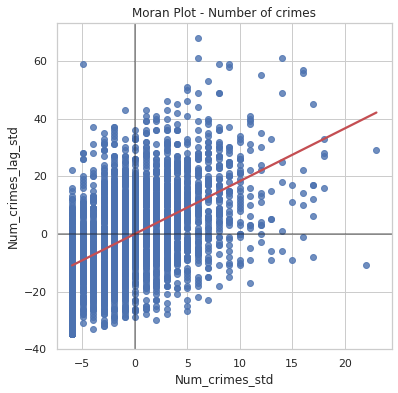

In [ ]:
gdf_norm['Num_crimes_std'] = (gdf_norm["Num_crimes"] - gdf_norm["Num_crimes"].mean())
gdf_norm['Num_crimes_lag_std'] = (gdf_norm["Num_crimes_lag"] - gdf_norm["Num_crimes_lag"].mean())

f, ax = plt.subplots(1, figsize=(6, 6))

sns.regplot(
    x='Num_crimes_std',
    y='Num_crimes_lag_std', 
    ci=None,
    data=gdf_norm,
    line_kws={'color':'r'}
)
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - Number of crimes')
plt.show()

f.savefig("Moran_scatter_plot")

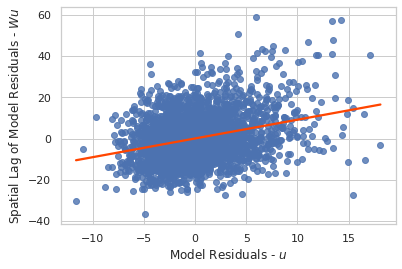

In [ ]:
lag_residual = weights.spatial_lag.lag_spatial(wr, m1.u)

ax = sns.regplot(
    m1.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

In [ ]:
moran = esda.moran.Moran(gdf_norm["Num_crimes"], wr)
moran.I, moran.p_sim, moran.z_rand

(0.2875853669239851, 0.001, 26.17022662387384)

In [ ]:
geary = esda.geary.Geary(gdf_norm["Num_crimes"], wr)
geary.C, geary.p_sim, geary.z_rand

(0.7131757413505316, 0.001, -25.751657497541647)

The Moran's I (0.287) and Geary's C (0.713) shows Positive Spatial Autocorrelation in the Number of Crimes with statistical significance. The null hiphotesys of spatial randomness is rejected (p-value of 0.001). On the other hand, residual plot shows that our prediction errors tend to group or cluster. 

We check that our variable and their residuals tend to cluster, we need to check some assumptions of substantive and residual spatial autocorrelation to choose the correct spatial model (Rey, Arribas-Bel, and Wolf, 2020). We put the weighted matrix in the OLS model to check the different indexes 

In [ ]:
#Fits OLS model with weigthed matrix

m3 = spreg.OLS(
    #Dependent variable
    gdf_norm[["Num_crimes"]].values,
    # Independent variables
    gdf_norm[second_variables].values,
    #Weights
    w = wr,
    spat_diag = True,
    # Dependent variable name
    name_y = "Num_crimes",
    # Independent variable name
    name_x = second_variables,
    robust = "white")

print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Num_crimes                Number of Observations:        2941
Mean dependent var  :      5.9725                Number of Variables   :          19
S.D. dependent var  :      4.5750                Degrees of Freedom    :        2922
R-squared           :      0.3499
Adjusted R-squared  :      0.3459
Sum squared residual:   40003.646                F-statistic           :     87.3806
Sigma-square        :      13.691                Prob(F-statistic)     :  6.611e-257
S.E. of regression  :       3.700                Log likelihood        :   -8011.428
Sigma-square ML     :      13.602                Akaike info criterion :   16060.856
S.E of regression ML:      3.6881                Schwarz criterion     :   16174.600

White Standard Errors
-------------------------------------------------------

Using the robust lagrange multiplier for lag and error test we could identify if substantive and residual spatial autocorrelation is presented. The probability is less than 0.05 for residual spatial autocorrelation and higher than 0.05 for substantive spatial autocorrelation consequently we need to consider it in the spatial model. We are going to built an spatial error model to consider their residual spatial autocorrelation (Rey, Arribas-Bel, and Wolf, 2020).

##### 3.3.1 Spatial Error Model

In [ ]:
#Fits Spatial Error model

m5 = spreg.ML_Error(
    #Dependent variable
    gdf_norm[["Num_crimes"]].values,
    # Independent variables
    gdf_norm[second_variables].values,
    #Weights
    w = wr,
    # Dependent variable name
    name_y = "Num_crimes",
    # Independent variable name
    name_x = second_variables)

print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Num_crimes                Number of Observations:        2941
Mean dependent var  :      5.9725                Number of Variables   :          19
S.D. dependent var  :      4.5750                Degrees of Freedom    :        2922
Pseudo R-squared    :      0.3473
Sigma-square ML     :      12.509                Log likelihood        :   -7924.537
S.E of regression   :       3.537                Akaike info criterion :   15887.074
                                                 Schwarz criterion     :   16000.817

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

We need to consider that Crimes Data were simulated in San Jose. This explicative model show us an example of how can we model Crimes Data considering built environment and socio demographic variables in the region. From the model results we can interpret the following (considering that number of crimes are simulated):

1. Point of interests represent an increase in the number of crimes with statistical significance.
2. In general number of heritage buildings and pedestrian areas have the highest possitive correlation with the the number of crimes. 
3. Other variables with higher possitive correlation and statistical significance with crimes are: pedestrian zones, number of properties, longitude of boulevards, local, main and other roads. In general, the presence of public space increase the number of crimes.
4. The presence of water bodies have a negative correlation with Number of Crimes with statistical significance. 
5. Recreation, condos areas with land use (commercial, institutional, mixed, and residential) decrease the number of crimes.
6. Population in the polygon area has a negative correlation with Number of Crimes.
7. The spatial error model shows that the neighbours variables in the model have an important influence in the number of crimes, consequently we need to improve the hot spots areas in a comprehensive way to reduce the incidents related to crimes.


These findings show us that roads and public space could increase the number of crimes (based on the simulation) and the land use combination of institutional, commercial, residental could increase safety.

#### 3.4. Conclussions

The spatial model was built in three steps: crime cases simulation, checking OLS and spatial autocorrelation and choosing the spatial model. The crime cases simlation considered built environment variables and a qualitative safety index. Our assumption, considering the sexual harassment data, was that data need to be complemented to increase their predictability. We propose a colaborative mapping to geolocated crimes in Costa Rica in order to enrich the data about. On the other hand, we construct built environment variables through geographical datasets. We check spatial autocorrelation to choose the best spatial model for the data. At the end, spatial error model was choosen considering the presence of residual spatial autocorrelation.

This model is for explanatory purposes consequently we do not need to cross validate. If we eant to use it to forecast crimes in the space we need to consider other assumptions.

### 4. Demo preparation


A big part of our focus is to give visibility to the risks that women in San Jose are expose to. Both to the women who day to day face these abuses and to entities that could help steer San Jose towards a safer environment for women.

With this idea in mind, we want to design the principal aspects of our demo [(link)](https://gender-s3-7kvbiho2qa-uc.a.run.app), which will combine the following:

1. Spatial risk index visualization, which uses data from the risk reporting form. this form allows women to report cases of sexual harassment in the streets.
2. Risk factor model, which also uses data from the risk reporting form to correlate with many geospatial factors, as seen on the previous section
3. Forecast of current violence trends against women, which uses historical reported data in san jose

For the demo, we have identified two main audiences

1. Women which could use the data(visualized in a demo) to understand in which parts of the city they are facing greater risks
2. People of entities interested in diving deeper in the data and understanding factors that are correlated with risk and also future trends of violence against women

In this section, we want to address the main design concerns in the demo such that we show accurate and appropiate information.


In [ ]:
BASE_PATH = '/content/drive/MyDrive/GeoNEAS/gender-s3/data'

#### 4.1. Risk index visualization

A huge objective is to be able to give a spatial visualization of a notion of risk for violence agains women across the city. 

By the beginning of this notebook, we discussed that the simplest data to work with to build a notion of risk would be total cases. Following this idea, we developed the risk model accordingly, also the forecast.

We also recognize that while the number of cases might be easier to interpret, we could go a step further and simplify the notion of risk by segmenting the cases into levels of risk. Thus intuitively, areas with low prevalence could be classified as relatively low risk while areas with a high number of cases could be classified as high risk. Outliers of unusually high cases would be characterized as very high risk.

Now, we build the risk map from the collected counts(of syntetic data). Here we imagine the counts are fixed in a constant period. For future work it is important to either pick a period (last 3 months) or take the average across periods(monthly average cases)

Here we load the data with risk variables per polygon. Next we load the georeferenced cases gathered in the reporting form.

In [ ]:
risk_features = gpd.read_file(f'{BASE_PATH}/model_input/hex_predict_whitout_crimes_HEX_10.geojson')
risk_features.columns

Index(['h3_polyfill', 'index', 'OBJECTID', 'Id_Distrito', 'Nombre',
       'Shape.STArea()', 'Shape.STLength()', 'Area_calc', 'Area_hex',
       'POB2016', 'POB2017', 'POB2018', 'Pop_hex', 'count_pois', 'pois_ha',
       'count_heritage', 'water_ha', 'ped_ha', 'parks_ha', 'recre_ha',
       'condos_ha', 'num_prop', 'num_churches', 'num_malls', 'communal_ha',
       'basic_ha', 'basic_count', 'higher_ha', 'higher_count', 'culture_ha',
       'admin_ha', 'green_ha', 'health_count', 'sec_count', 'assist_count',
       'risky_f_ha', 'Other_use', 'commercial', 'institutional', 'mixed',
       'recreational', 'residential', 'boulevards', 'local', 'main',
       'other_roads', 'pedestrian', 'geometry'],
      dtype='object')

In [ ]:
basemap = risk_features[['h3_polyfill', 'geometry']]

Load and group the cases per grid hexagon

In [ ]:
cases = gpd.read_file(f'{BASE_PATH}/model_input/simulated_cases.geojson')
cases_breakdown = (cases
                .groupby(['weekday', 'time_of_day'])
                .apply(lambda g: g[['geometry']].assign(cases=1).h3.geo_to_h3_aggregate(10, return_geometry=False)).reset_index())

cases_breakdown.sample(3)

weekday time_of_day            h3_10  cases
13574        6     4_night  8a6d69329167fff      1
1540         0     4_night  8a6d69adb71ffff      1
285          0   1_morning  8a6d69ada767fff      1

We decided to group by area only though in the future we might group by other variables suchs as time of the day to for example visualize risk at different times.

In [ ]:
cases_grouped = cases_breakdown.groupby('h3_10').agg({'cases': 'sum'})

basemap_cases = basemap.merge(cases_grouped, left_on='h3_polyfill', right_on='h3_10', how='left')
basemap_cases['cases'] = basemap_cases['cases'].fillna(0)
basemap_cases.sample(3)

h3_polyfill                                           geometry  \
2359  8a6d69ad964ffff  POLYGON ((-84.09253 9.94728, -84.09312 9.94690...   
1986  8a6d69adb2effff  POLYGON ((-84.10747 9.93923, -84.10806 9.93885...   
2210  8a6d693664b7fff  POLYGON ((-84.10715 9.93525, -84.10774 9.93487...   

      cases  
2359    0.0  
1986   10.0  
2210    0.0

In [ ]:
fig = px.choropleth_mapbox(
    basemap_cases,
    geojson=basemap_cases.geometry,
    locations=basemap_cases.index,
    color="cases",
    opacity=0.6,
    center={"lat": basemap_cases.unary_union.centroid.y, "lon": basemap_cases.unary_union.centroid.x},
    zoom=12,
    color_continuous_scale='YlOrRd',
    mapbox_style="open-street-map",)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

This could be plot to give an idea of risk as we discussed before. However, we would like to give a much easier to interpret classification. We do this analysis and subsequent mapping next.

#### 4.2 Simple risk index

Now we work on the objective of turn the risk index into something easier to digest for public audiences. For the number of cases, we can think of an appropiate categorization. 

Lets check the density.

In [ ]:
alt.Chart(basemap_cases).transform_density(
    'cases',
    as_=['cases', 'density'],
).mark_area().encode(
    x="cases:Q",
    y='density:Q',
).properties(
    title='cases distribution per hexagon'
)

alt.Chart(...)

We expect to see a distribution similar to this one on real reported data on the app. In order to transform these numbers to something more understandable, we decided to go with a partition of the data in categories(ie. *very low risk, low risk, moderate risk, high risk, very high risk*)

In the beginning we were contemplating percentiles of the values, this would have the advantage of allowing the distributions shape the categories. Nonetheless such approach has two glaring weaknesses. 

First, basing the categories on data only could for example form a category that contains numbers which might not be in accordance to the perception of for example relatively low risk, even if the distribution outputs some values. Second, it would be difficult to assess something such as improvement or worsening of the situation of risk as the breaks of the categories will always adapt to the data. One example: even if all zones report very few cases, some will always be classified as low risk

Based on the previous discussion, we decided to go with an scheme where the breaks of the values to transform into categories is fixed. This will allow the input of experts in the topics of violence and also the possible assesment of an overall improvement or worsening of the violence situation. After all, the end goal would be to see all the map as low risk.

We define the following breaks in order to separate the distribution into 5 categories. On future iterations, the idea is to show the data and distributions to experts and get their feedback on appropiate ranges of values for each category.

In [ ]:
risk_categories = ['very low risk', 'low risk', 'moderate risk', 'high risk', 'very high risk']
breaks = [0, 2, 5, 10, 20, np.inf]

In [ ]:
basemap_cases['risk_index'] = pd.cut(basemap_cases['cases'], bins=breaks, right=False, include_lowest=True, labels=risk_categories)

colors_scale = ['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026']
color_map = {risk: color for risk, color in zip(risk_categories, colors_scale)}

With this intervals, we can transform the cases data into risk categories

In [ ]:
fig = px.choropleth_mapbox(
    basemap_cases,
    geojson=basemap_cases.geometry,
    locations=basemap_cases.index,
    color="risk_index",
    opacity=0.6,
    center={"lat": basemap_cases.unary_union.centroid.y, "lon": basemap_cases.unary_union.centroid.x},
    zoom=12,
    color_discrete_map=color_map,
    mapbox_style="open-street-map",)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

This map seems a bit cleaner compared to the previous case only map. Another advantage of this approach is that were we to change the way to measure risk, for example by dividing cases/population in the area. We could still keep the categories of risk, we will just neet to redefine intervals, so to the users(woman) it would be more transparent and they wont have to familiarize with an entirely different way to interpret risk.

We decided to redo this map in folium for the demo since the interactivity option was much better. Please find the code in the repo.

Now, we exported this data to use it on the demo. Thinking in production, these numbers could be aggregated daily or every certain period.

In [ ]:
(basemap_cases
 .assign(risk_index = lambda x: x.risk_index.astype(str))
 .to_file(f'{BASE_PATH}/results/cases_risk_index.geojson', driver='GeoJSON'))

#### 4.3. Factors model results and maps

We also developed a model that tries to correlate different factors with the overall risk(or prevalence of cases) in order to help entities interested in improving spaces por women understand the factors and their importance. We based these factors on current research (Garfias Royo, Parikh, and Belur 2020; Sánchez 2021; Gargiulo et al. 2020) both qualitative and quantitative.

One key aspect of the factors is that we selected the factors to be in a sense actionable, that is that they could be changed or acted upon, and if not actionable, at least they could be intuitive. For example the presence of security or guvermental buildings nearby. Or the population density.

To help aid interpret the factors, we though of two main ways:

1. Visualize the importance of a factor and its effect(is it correlated with increased risk or decreased risk?).
2. Visualize maps of the factors to form an idea at a glance of the situation.

Combining both, people looking at both the factors and the plotted maps can infer from their domain expertise what ways the city can be improved in particular areas. Also from what factors they can start acting (presence of security for example). We hope this can also jumpstart particular investigations into certain correlations, for example if particular configurations of built environment tend to gather more cases.

##### 4.3.1. Model coefficient analysis

Table of coefficients and analysis of effects, here we are interested in seeing which are significant and in what direction they correlate(more risk, less risk).

We load the coefficients of the model developed in the spatial model

In [ ]:
model_coefficients = pd.read_parquet(f'{BASE_PATH}/results/spatialerror_model_coeficients.parquet')
model_coefficients.sample(5)

Variable Coefficient Probability
18        Pop_hex   -1,294625    0,000812
11  institutional   -2,028508    0,000021
6        recre_ha   -4,411002    0,000002
5        water_ha   -1,717803    0,000000
13    residential   -0,945729    0,079181

Some preprocessing of the coefficients.

In [ ]:
model_coefficients = model_coefficients.apply(lambda c: c.str.replace(',', '.'))
model_coefficients['Coefficient'] = model_coefficients['Coefficient'].astype(float)
model_coefficients['Probability'] = model_coefficients['Probability'].astype(float)

model_coefficients['abs_Coefficient'] = model_coefficients['Coefficient'].abs()
model_coefficients['increased_risk'] = model_coefficients['Coefficient'] > 0

Here we filter those that are significant according to a 95% significance threshold.

In [ ]:
sig_model_coefficients = model_coefficients.query('Probability<0.05')

alt.Chart(sig_model_coefficients).mark_bar().encode(
    x=alt.X('Coefficient:Q'),
    y=alt.Y('Variable:N', sort='-x'),
    tooltip=['Variable', 'Coefficient', 'Probability'],
    color=alt.Color(
        'increased_risk:O',
        scale=alt.Scale(domain=[True, False],range=['#EB5353', '#36AE7C']))
)

alt.Chart(...)

This is the chart that at a glance can inform wether certain variable is correlated with increased or decreased risk and also how big that effect might be. Since the model used normalized variables. We can interpret larger coefficients as being more correlated, or 'heavier'. Thus in our sintetic data, the main roads would be correlated the most with violence cases. Policy makers could then focus their attention on what is making main roads concentrate violence.

##### 4.3.2. Interpreting variables for mapping

To complement the coefficients, we wanted to give a way to visualize the variables such that hipotheses and ideas could be formed quickly. For example following the importance of main roads as a key factor correlated with risk, entities and policy makers might want to visualize the spatial distribution of this variable, in order to understand in which areas they might focus, or start their investigations.

Here we load the normalized features that were input into the model. We are going to map the most significant variables.

In [ ]:
model_features_norm = pd.read_parquet(f'{BASE_PATH}/model_input/model_gdf_norm.parquet')
model_features_norm.sample()

h3_polyfill  index  OBJECTID  Id_Distrito         Nombre  \
1311  8a6d69360657fff      6        80           11  SAN SEBASTIÁN   

      Shape.STArea()  Shape.STLength()  Area_calc  Area_hex  POB2016  ...  \
1311    3.947736e+06      11936.736487   0.000326  0.000001    44707  ...   

      institutional  mixed  residential  boulevards     local  main  \
1311            0.0    0.0     0.620013         0.0  0.250108   0.0   

      other_roads  Pop_hex                                           geometry  \
1311          0.0  0.80257  b"\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00...   

      Num_crimes  
1311          13  

[1 rows x 32 columns]

In [ ]:
sig_variables = [v for v in sig_model_coefficients.Variable.unique().tolist() if v not in ['CONSTANT', 'lambda']]
sig_variables

['count_pois',
 'count_heritage',
 'ped_ha',
 'water_ha',
 'recre_ha',
 'condos_ha',
 'num_prop',
 'commercial',
 'institutional',
 'mixed',
 'boulevards',
 'local',
 'main',
 'other_roads',
 'Pop_hex']

In [ ]:
model_features_norm = model_features_norm[['h3_polyfill'] + sig_variables]
model_features_norm = model_features_norm.melt(
    id_vars=['h3_polyfill'], var_name='variable', value_name='value')

model_features_norm.sample(3)

h3_polyfill     variable     value
41373  8a6d69366147fff      Pop_hex  0.408827
32061  8a6d69adbd67fff   boulevards  0.000000
39840  8a6d69ada48ffff  other_roads  0.218713

##### 4.3.3. Maps of the factors

Small multiple of the different factors, allows for filtering and replotting, this could also be implemented in the demo by a filter on which variables to map.

In [ ]:
fig = px.choropleth(
    model_features_norm,
    locations=model_features_norm.h3_polyfill,
    geojson = basemap.set_index('h3_polyfill').geometry,
    #featureidkey='h3_polyfill',
    color="value",
    facet_col='variable',
    facet_col_wrap=3,facet_row_spacing=0,facet_col_spacing=0,
    center={"lat": basemap_cases.unary_union.centroid.y, "lon": basemap_cases.unary_union.centroid.x},
    color_continuous_scale='dense',
    #fitbounds='locations'
    )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},width=1200,height=1200,dragmode=False)
fig.update_geos(fitbounds="locations", visible=False)
fig.update_traces(marker_line_width=0)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

####4.4. Regionalization to simplify policy making

While developing these visualizations, we noticed that the high density of zones sometimes could be hard to interpet. For example in policy making we can gather that even recognizing the factors we have to rely on the policy maker to design or recognize a bigger geographical zone to further investigate or to intervene there.

To aid in this process, we propose a method to form bigger areas that would be easier to handle. There are different options

- One approach would be to use nieighborhoods or census zones, unfortunately, we found no easy access to such data
- Another approach is to use a greater aggregation of the hexagonal grid were using to form bigger hexagons, this is quite useful but might imply forming areas wher the variables are very dissimilar in a boundary
- As a data driven approach, we think that a clustering method could help extract regions that are similar in their variables and thus easier to handle for a policy maker since it could be expacted that the behavior of these zones would be similar. Here we did a bit of research on clustering that takes into account the spatial component. This is called regionalization(https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html, https://www.dshkol.com/post/spatially-constrained-clustering-and-regionalization/). There are different algorithms that we could evaluate here.

However, due to time constraints we did not have enough time to dig deeper and implement such methods. We still leave the discussion here since it might be a good first future improvement of the tool.

#### 4.5. Forecast trends

The risk index mapping and factors will allow entities advocating for woman safety to understand the current situation of violence(given colelcted data in the reporting tool). On the other hand, this forecast prediction aids understanding the trends in data and specially projected trends of violence from current reported trends.

We remind that for this forecast we use reported historical data to the authorities, which has district-level granularity.

In [ ]:
# Load trends and forecast data and plot it
forecast = pd.read_parquet(f'{BASE_PATH}/results/district_forecasts.parquet')
forecast.head()

ds      yhat  yhat_lower  yhat_upper     trend  trend_lower  \
0 2022-04-01  3.947058    1.504656    6.639435  3.947058     3.947058   
1 2022-05-01  3.903848    1.468107    6.423158  3.903848     3.903848   
2 2022-06-01  3.859197    1.373328    6.261971  3.859197     3.859197   
3 2022-07-01  3.815987    1.224090    6.259894  3.815987     3.815987   
4 2022-08-01  3.771337    1.085912    6.227562  3.771337     3.771337   

   trend_upper districts target  
0     3.947058    CARMEN      y  
1     3.903848    CARMEN      y  
2     3.859197    CARMEN      y  
3     3.815987    CARMEN      y  
4     3.771337    CARMEN      y

In [ ]:
forecast.sort_values(['districts', 'ds'])

ds      yhat  yhat_lower  yhat_upper     trend  trend_lower  \
0  2022-04-01  3.947058    1.504656    6.639435  3.947058     3.947058   
1  2022-05-01  3.903848    1.468107    6.423158  3.903848     3.903848   
2  2022-06-01  3.859197    1.373328    6.261971  3.859197     3.859197   
3  2022-07-01  3.815987    1.224090    6.259894  3.815987     3.815987   
4  2022-08-01  3.771337    1.085912    6.227562  3.771337     3.771337   
..        ...       ...         ...         ...       ...          ...   
16 2023-08-01  0.195677   -1.775375    2.142900  0.195677     0.195677   
17 2023-09-01  0.071030   -1.851697    1.900754  0.071030     0.071030   
18 2023-10-01 -0.049596   -1.849372    1.757031 -0.049596    -0.049597   
19 2023-11-01 -0.174244   -2.068011    1.776075 -0.174244    -0.174244   
20 2023-12-01 -0.294870   -2.152461    1.420914 -0.294870    -0.294870   

    trend_upper districts target  
0      3.947058    CARMEN      y  
1      3.903848    CARMEN      y  
2      3.859197    CARMEN      y  
3      3.815987    CARMEN      y  
4      3.771337    CARMEN      y  
..          ...       ...    ...  
16     0.195677    ZAPOTE      y  
17     0.071030    ZAPOTE      y  
18    -0.049596    ZAPOTE      y  
19    -0.174243    ZAPOTE      y  
20    -0.294869    ZAPOTE      y  

[231 rows x 9 columns]

The plot is sinple since it only shows the projected trends 

In [ ]:
alt.Chart(forecast).mark_line().encode(
    x='ds:T',
    y='trend:Q',
    color='districts'
)

alt.Chart(...)

#### 4.6. Conclisions and future work

In this section, we showed the design and decisions that form the foundations of the demo tool, which we hope will be a useful tool for women to figure out at a glance where they could enjoy public safe spaces, or avoid risky spaces. And for entities(which could also be women wanting to dive into the data and promote change) that want to change the situation to understant the factors and where they could start acting or investigating more factors that correlate with violence against women.

There are some important points of future improvement and work:

- We hope to define a risk index that takes a bit more into account the prevalence given the population that crosses the area.
- We also hope to incorporate into the risk factor the importance of time.
- It would be nice to combine historical official data and data collected in the reporting tool. In fact the reporting tool also helps considering those cases that were also reported to the police.
- Following the previous point, we hope that the tool can incorporate the insights og a model that not only takes into account spatial relations of different zones, but temporal relations as well. Though we infer this model would be quite data hungry and its implementation might be more challenging, as well as its interpretation
- Even when we tried to have anonimity to reduce the friction of reporting in gender-based violence incidents (Rodas-Zuleta, Cardona, and Escobar 2022), we are aware taht a subreporting bias will exists, in the future we hope to develop models and data callibration to address better this underreporting 

## 🖼️ Visualisations 

**Number of Crimes per category**

![Number_crimes_general.png](https://storage.googleapis.com/geoneas-bucket/gender-s3/images_resized/Number_crimes_general.png)



**Sexual harassment crimes**

![Crimes_per_province_sexualharassment.png](https://storage.googleapis.com/geoneas-bucket/gender-s3/images_resized/Crimes_per_province_sexualharassment.png)

**Risk Score Index and Lag variables**

![Risk_score_general.png](https://storage.googleapis.com/geoneas-bucket/gender-s3/images_resized/Risk_score_general.png)

![Number_crimes_Lag_variables.png](https://storage.googleapis.com/geoneas-bucket/gender-s3/images_resized/Number_crimes_Lag_variables.png)


**Coefficient variables**

![demo_model_coefficients.png](https://storage.googleapis.com/geoneas-bucket/gender-s3/images_resized/demo_model_coefficients.png)


## 👓 References

[1] Report from ECLAC (Economic Commission for Latin America and the Caribbean) on violence against women and girls.  
(https://www.cepal.org/en/pressreleases/eclac-persistence-violence-against-women-and-girls-region-and-femicide-its-maximum)

[2] Garfias Royo, M., Parikh, P., & Belur, J. (2020). Using heat maps to identify areas prone to violence against women in the public sphere. _Crime Science_, _9_(1), 1–15. https://doi.org/10.1186/s40163-020-00125-6

[3] Sánchez, Y. (2021). _Implementation of a spatial database for the calculation of safety indexes for women in public spaces_. _20_(1), 3550–3555. https://doi.org/10.17051/ilkonline.2021.01.400

[4] Rodas-Zuleta, M. del M., Cardona, S., & Escobar, D. A. (2022). Gender-based violence and Women’s mobility, findings from a medium-sized Colombian city: A quantitative approach. _Journal of Transport & Health_, _25_(April), 101376. https://doi.org/10.1016/j.jth.2022.101376

[5] Manazir, S. H., Govind, M., & Rubina. (2019). My safetipin mobile phone application: Case study of e-participation platform for women safety in India. _Journal of Scientometric Research_, _8_(1), 47–53. https://doi.org/10.5530/jscires.8.1.7

[6] Rey, S.J, Arribas-Bel, D, & Wolff, L.J. (2020). Geographic Data Science with Python. Retrieved from: https://geographicdata.science/book/intro.html



## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.
